In [13]:
import sys
sys.path.append("../")
import numpy as np
import csv
import os
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import scripts.theodolite_utils as theodo_u
theodo_u = importlib.reload(theodo_u)
import warnings
warnings.filterwarnings('ignore')
from scipy.spatial.transform import Rotation as R_scipy

## Select date of the data to compute

In [14]:
# Path of output
date = "20230725-1"
path = "../data/"+ date + "/"

## 0. Import Data & Synchronize RTS Timestamp with GNSS Timestamp

In [15]:
theodo_u = importlib.reload(theodo_u)

df_rts = pd.read_csv(path + "ground_truth/groundtruth_rts_lidar.csv", names=["Timestamp", "X", "Y", "Z", "qx", "qy", "qz", "qw"], delimiter= ' ')
df_gps = pd.read_csv(path + "ground_truth/groundtruth_gps_lidar.csv", delimiter= ',')

df_rts['Timestamp'] = pd.to_datetime(df_rts['Timestamp'], unit='s') # Convert to datetime
print(df_rts['Timestamp'][0])
df_rts['Timestamp'] -= pd.Timedelta(hours=4, seconds=6) # Subtract 4 hours from the RTS Timestamp column
df_rts['Timestamp'] = df_rts["Timestamp"].values.astype(np.int64) // (1*10 ** 9) # Convert to Unix Timestamp

2023-07-25 18:53:27.509321728


## 1. Plot GPS and RTS data

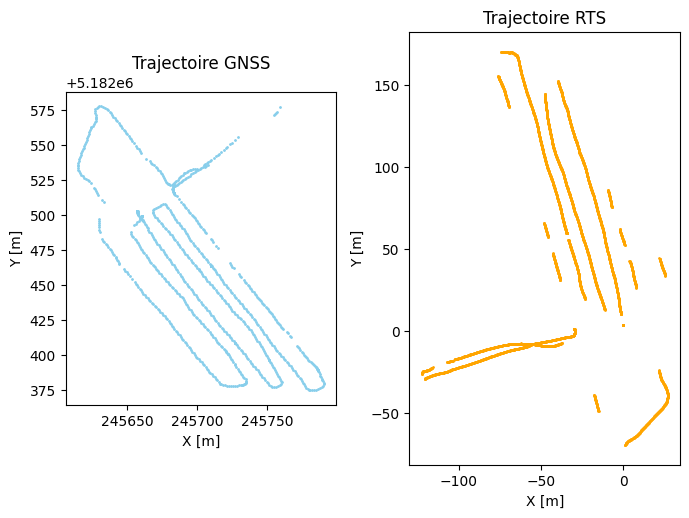

In [16]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(7, 6), ncols=2, nrows=1)
ax[0].scatter(df_gps['X'], df_gps['Y'], s=1, c='skyblue')
ax[0].set_xlabel('X [m]')
ax[0].set_ylabel('Y [m]')
ax[0].set_title('Trajectoire GNSS')
ax[0].set_aspect('equal')
ax[1].scatter(df_rts['X'], df_rts['Y'], s=1, c='orange')
ax[1].set_xlabel('X [m]')
ax[1].set_ylabel('Y [m]')
ax[1].set_title('Trajectoire RTS')
ax[1].set_aspect('equal')
# ax[1].invert_xaxis()
# ax[1].invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.expanduser('~') + '/Master_thesis/Figures/gt_raw.pdf')

## 2. Compute transformation matrix from RTS frame to GNSS frame : $T_{RTS}^{GNSS}$.

In [17]:
traj_merge = pd.merge(df_rts[['Timestamp', 'X', 'Y', 'Z', 'qx','qy','qz','qw']], df_gps[['Timestamp', 'X', 'Y', 'Z', 'qx','qy','qz','qw','PDOP','Sats']], on=['Timestamp'], how='outer', indicator=True)
traj_common = traj_merge[traj_merge['_merge'] == 'both']
traj_gps_only = traj_merge[traj_merge['_merge'] == 'right_only']
traj_rts_only = traj_merge[traj_merge['_merge'] == 'left_only']

traj_common.rename(columns={'X_x':'X_rts', 'Y_x':'Y_rts', 'Z_x':'Z_rts', 'X_y':'X_gps', 'Y_y':'Y_gps', 'Z_y':'Z_gps'}, inplace=True)
traj_gps_only.rename(columns={'X_y':'X', 'Y_y':'Y', 'Z_y':'Z', 'qx_y' : 'qx', 'qy_y' : 'qy', 'qz_y' : 'qz', 'qw_y' : 'qw'}, inplace=True)
traj_rts_only.rename(columns={'X_x':'X', 'Y_x':'Y', 'Z_x':'Z', 'qx_x' : 'qx', 'qy_x' : 'qy', 'qz_x' : 'qz', 'qw_x' : 'qw'}, inplace=True)

traj_gps_only.drop(['X_x', 'Y_x', 'Z_x', 'qx_x', 'qy_x', 'qz_x', 'qw_x', '_merge'], axis=1, inplace=True)
traj_rts_only.drop(['X_y', 'Y_y', 'Z_y', 'qx_y', 'qy_y', 'qz_y', 'qw_y', 'PDOP', 'Sats', '_merge'], axis=1, inplace=True)

In [18]:
P = np.array([traj_common['X_rts'], traj_common['Y_rts'], traj_common['Z_rts'], np.ones(len(traj_common['X_rts']))])
Q = np.array([traj_common['X_gps'], traj_common['Y_gps'], traj_common['Z_gps'], np.ones(len(traj_common['X_gps']))])

T = theodo_u.point_to_point_minimization(P, Q)
P = T @ P

traj_common['X_rts'] = P[0,:]
traj_common['Y_rts'] = P[1,:]
traj_common['Z_rts'] = P[2,:]

P_rts = np.array([df_rts['X'], df_rts['Y'], df_rts['Z'],np.ones(len(df_rts['X']))])
P_rts = T @ P_rts
df_rts['X'] = P_rts[0,:]
df_rts['Y'] = P_rts[1,:]
df_rts['Z'] = P_rts[2,:]

P_traj_rts_only = np.array([traj_rts_only['X'], traj_rts_only['Y'], traj_rts_only['Z'], np.ones(len(traj_rts_only['X']))])
P_traj_rts_only = T @ P_traj_rts_only
traj_rts_only['X'] = P_traj_rts_only[0,:]
traj_rts_only['Y'] = P_traj_rts_only[1,:]
traj_rts_only['Z'] = P_traj_rts_only[2,:]

## Check timestamp sync

Text(0, 0.5, 'X [m]')

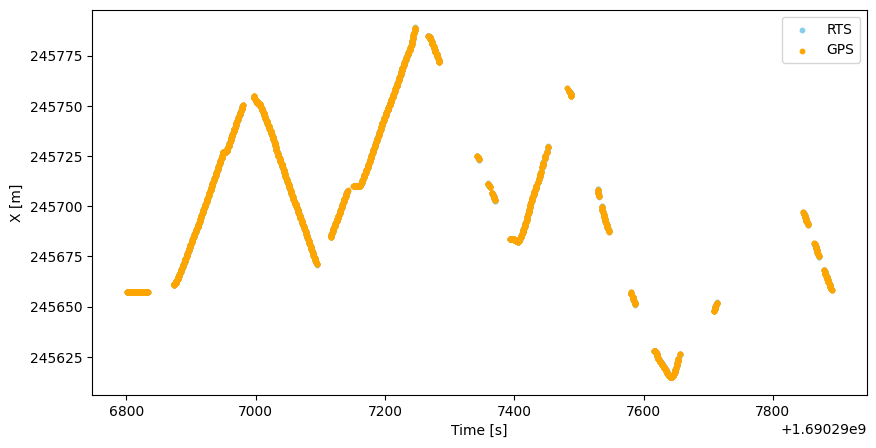

In [19]:
plt.figure(figsize=(10, 5))
plt.scatter(traj_common['Timestamp'], traj_common['X_rts'], c='skyblue', label='RTS', s=10)
plt.scatter(traj_common['Timestamp'], traj_common['X_gps'], c='orange', label='GPS', s=10)
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('X [m]')

## 2. GPS only, RTS only and common trajectory

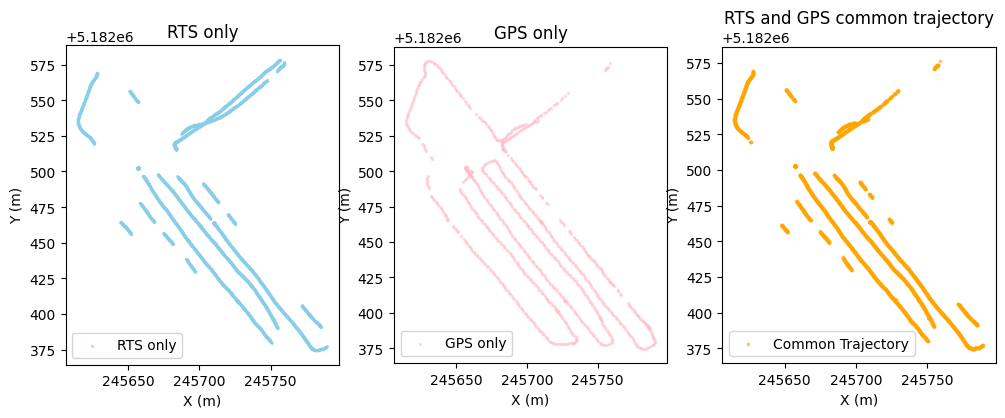

In [20]:
fig, ax = plt.subplots(figsize=(12, 12), ncols = 3, nrows = 1)
ax[0].scatter(df_rts['X'],df_rts['Y'], c='skyblue', label='RTS only', s=2, alpha = 0.5)
ax[1].scatter(df_gps['X'], df_gps['Y'], c='pink', label='GPS only', s=2, alpha=0.5)
ax[2].scatter(traj_common['X_rts'], traj_common['Y_rts'], c='orange', label='Common Trajectory', s=3, alpha=0.5)


ax[0].set_xlabel('X (m)')
ax[0].set_ylabel('Y (m)')
ax[0].set_title('RTS only')
ax[0].legend(loc = 'lower left')
ax[0].set_aspect('equal')

ax[1].set_xlabel('X (m)')
ax[1].set_ylabel('Y (m)')
ax[1].set_title('GPS only')
ax[1].legend(loc = 'lower left')
ax[1].set_aspect('equal')

ax[2].set_xlabel('X (m)')
ax[2].set_ylabel('Y (m)')
ax[2].set_title('RTS and GPS common trajectory')
ax[2].legend(loc = 'lower left')
ax[2].set_aspect('equal')


## 3. Final plot with common trajectory

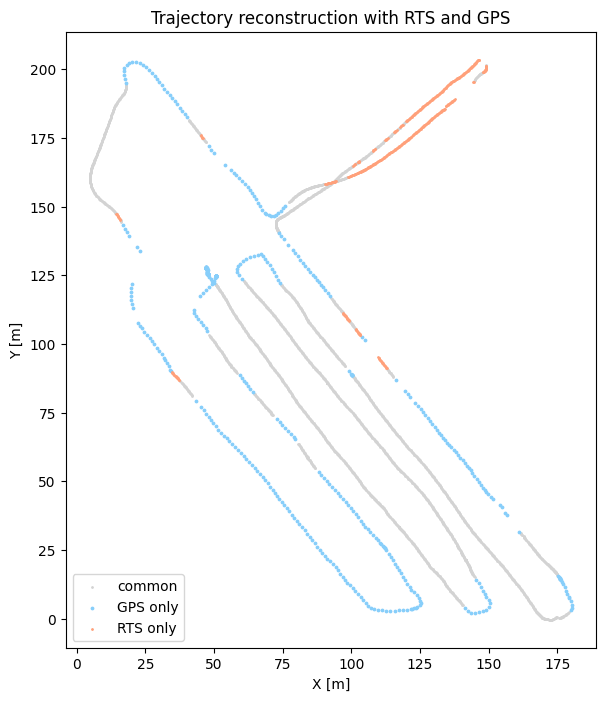

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(traj_common['X_rts']-245610, traj_common['Y_rts']-5182375, s=1, c='lightgrey', label = 'common')
ax.scatter(traj_gps_only['X']-245610, traj_gps_only['Y']-5182375, s=3, c='lightskyblue', label = 'GPS only')
ax.scatter(traj_rts_only['X']-245610, traj_rts_only['Y']-5182375, s=1, c='lightsalmon', label = 'RTS only')
ax.set_aspect('equal')
ax.legend()
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title('Trajectory reconstruction with RTS and GPS')
ax.set_aspect('equal')

## 5. Final comparaison between raw data and trajectory reconstruction

In [22]:
X_origin = 245610
Y_origin = 5182375
Z_origin = 62

Text(0.5, 0.68, 'First trajectory')

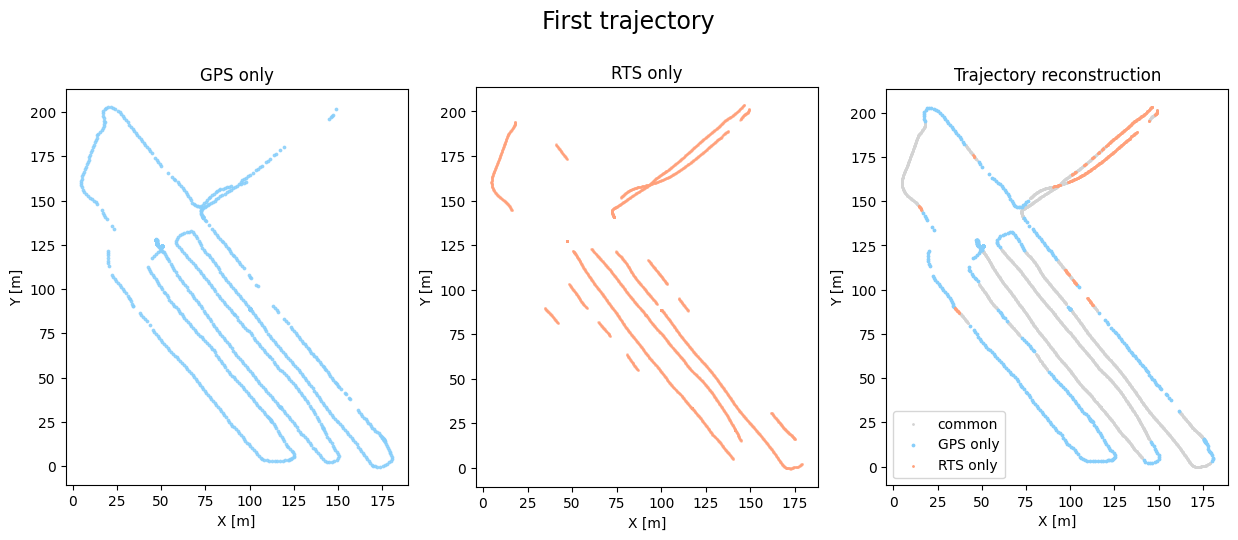

In [23]:
fig, ax = plt.subplots(figsize=(15, 15), ncols=3, nrows=1)

ax[0].scatter(df_gps['X']-X_origin, df_gps['Y']-Y_origin, s=3, c='lightskyblue', alpha=0.8)
ax[0].set_xlabel('X [m]')
ax[0].set_ylabel('Y [m]')
ax[0].set_title('GPS only')
ax[0].set_aspect('equal')

ax[1].scatter(df_rts['X']-X_origin, df_rts['Y']-Y_origin, s=1, c='lightsalmon', alpha=0.5)
ax[1].set_xlabel('X [m]')
ax[1].set_ylabel('Y [m]')
ax[1].set_title('RTS only')
ax[1].set_aspect('equal')

ax[2].scatter(traj_common['X_rts']-X_origin, traj_common['Y_rts']-Y_origin, s=1, c='lightgrey', label = 'common')
ax[2].scatter(traj_gps_only['X']-X_origin, traj_gps_only['Y']-Y_origin, s=3, c='lightskyblue', label = 'GPS only')
ax[2].scatter(traj_rts_only['X']-X_origin, traj_rts_only['Y']-Y_origin, s=1, c='lightsalmon', label = 'RTS only')
ax[2].set_aspect('equal')
ax[2].legend()
ax[2].set_xlabel('X [m]')
ax[2].set_ylabel('Y [m]')
ax[2].set_title('Trajectory reconstruction')
ax[2].set_aspect('equal')

fig.suptitle('First trajectory',fontsize=17, y=0.68)

# Figure : precision GPS and RTS

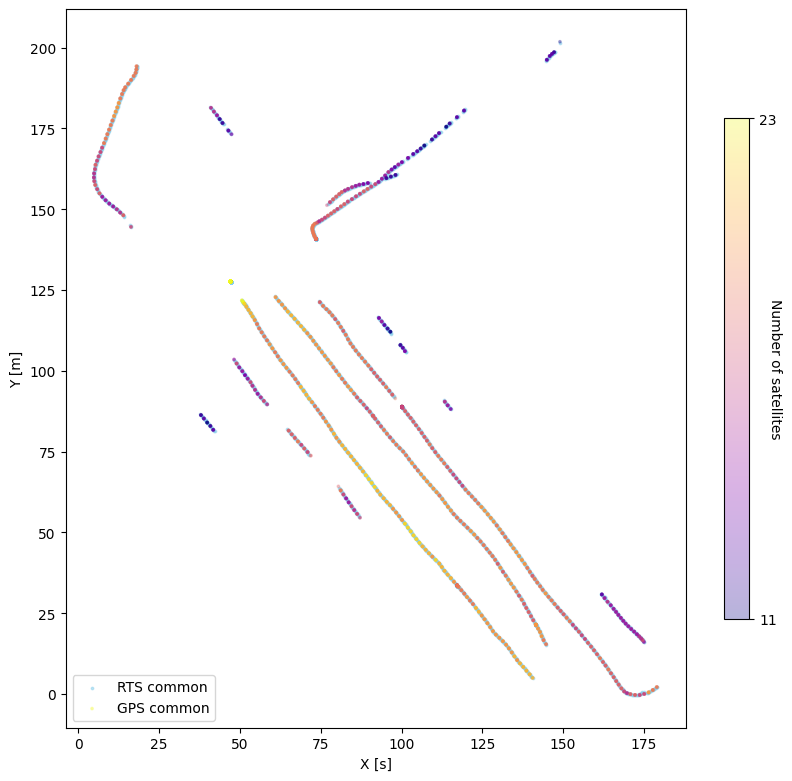

In [24]:
plt.figure(figsize=(10,10))
plt.scatter(traj_common['X_rts'] - X_origin, traj_common['Y_rts'] - Y_origin, c='skyblue', label='RTS common', s=3, alpha=0.5)
plt.scatter(traj_common['X_gps'] - X_origin, traj_common['Y_gps'] - Y_origin, cmap = 'plasma', c=traj_common['Sats'], label='GPS common', s=3, alpha=0.3)
plt.gca().set_aspect('equal')
plt.legend(loc = 'lower left')
plt.xlabel('X [s]')
plt.ylabel('Y [m]')

colorbar = plt.colorbar(shrink=0.65)
colorbar.set_label('Number of satellites', rotation=270)
colorbar.set_ticks([min(traj_common['Sats']), max(traj_common['Sats'])])

## To merge images :

In [25]:
from PIL import Image
def merge_images_vertically(image_path1, image_path2, output_path):
    # Ouvrir les deux images
    image1 = Image.open(image_path1)
    image2 = Image.open(image_path2)

    # Récupérer les dimensions des images
    width1, height1 = image1.size
    width2, height2 = image2.size

    # Calculer la largeur et la hauteur de l'image fusionnée
    merged_width = max(width1, width2)
    merged_height = height1 + height2

    # Créer une nouvelle image fusionnée
    merged_image = Image.new("RGB", (merged_width, merged_height), (255, 255, 255))

    # Coller les deux images dans l'image fusionnée
    merged_image.paste(image1, (0, 0))
    merged_image.paste(image2, (0, height1))

    # Enregistrer l'image fusionnée
    merged_image.save(output_path)

merge_images_vertically("/Users/effiedaum/Master_thesis/Figures/Plot_workshop/final_plot_1st.png", "/Users/effiedaum/Master_thesis/Figures/Plot_workshop/final_plot_2nd.png", "/Users/effiedaum/Master_thesis/Figures/Plot_workshop/final_plot_merged.png")

# 6. Error inter-prism and inter-gps

## 6.1 inter-prism

In [26]:
theodo_u = importlib.reload(theodo_u)
prefix = "filtered_prediction/f-2-2-2-3-6-0-L"
linear_interpolation = True
if(linear_interpolation==True):
    P1 = theodo_u.read_prediction_data_Linear_csv_file(path+prefix +"_1.csv")
    P2 = theodo_u.read_prediction_data_Linear_csv_file(path+prefix +"_2.csv")
    P3 = theodo_u.read_prediction_data_Linear_csv_file(path+prefix +"_3.csv")
else:
    P1 = theodo_u.read_prediction_data_GP_csv_file(path+prefix +"_1.csv")
    P2 = theodo_u.read_prediction_data_GP_csv_file(path+prefix +"_2.csv")
    P3 = theodo_u.read_prediction_data_GP_csv_file(path+prefix +"_3.csv")
    
P1_arr = np.array(P1)
P2_arr = np.array(P2)
P3_arr = np.array(P3)

path_file_GCP = "total_stations/GCP.txt"
file_name = path+path_file_GCP
trimble_1_gcp, trimble_2_gcp, trimble_3_gcp, T_1_grand, T_2_grand, T_3_grand = theodo_u.read_marker_file(file_name, 1, 1) #reference frame : theodolite 1

P1_corrected = []
P2_corrected = []
P3_corrected = []
for i, j, k in zip(P1_arr, P2_arr, P3_arr):
    P1_arr = T_1_grand@i[1:5].T
    P1_corrected.append([i[0], P1_arr[0], P1_arr[1], P1_arr[2], 1])
    P2_arr = T_2_grand@j[1:5].T
    P2_corrected.append([j[0], P2_arr[0], P2_arr[1], P2_arr[2], 1])
    P3_arr = T_3_grand@k[1:5].T
    P3_corrected.append([k[0], P3_arr[0], P3_arr[1], P3_arr[2], 1])

P1_corrected = np.array(P1_corrected)
P2_corrected = np.array(P2_corrected)
P3_corrected = np.array(P3_corrected)

extrinsic_calibration_results = theodo_u.read_extrinsic_calibration_results_file(path+"sensors_extrinsic_calibration/calibration_results.csv")

In [27]:
print(extrinsic_calibration_results)

[1.03304543784065, 0.6211003440288285, 0.8298205414855501, 1.0232781964393043, 0.5832249618085531, 0.8652673149776331]


In [28]:
d12_rts = []
d13_rts = []
d23_rts = []
diff_time_synchro = 4*3600+6
for i,j,k in zip(P1_corrected,P2_corrected,P3_corrected):
    d12_rts.append([i[0]-diff_time_synchro,1000*abs(np.linalg.norm(i[1:4]-j[1:4])-extrinsic_calibration_results[0])])
    d13_rts.append([i[0]-diff_time_synchro,1000*abs(np.linalg.norm(i[1:4]-k[1:4])-extrinsic_calibration_results[1])])
    d23_rts.append([j[0]-diff_time_synchro,1000*abs(np.linalg.norm(k[1:4]-j[1:4])-extrinsic_calibration_results[2])])

In [29]:
xs_rts = [None] * len(df_rts['Timestamp'])
for i in range(0,len(d12_rts)):
    out = next(iter(np.where(df_rts['Timestamp'] == np.int64(d12_rts[i][0]))), 'Nan')
    for j in out:
        if j!='Nan':
            if np.mean([d12_rts[i][1],d13_rts[i][1],d23_rts[i][1]])<10000:
                xs_rts[j]= np.mean([d12_rts[i][1],d13_rts[i][1],d23_rts[i][1]])
df_rts['Inter_prism'] = xs_rts

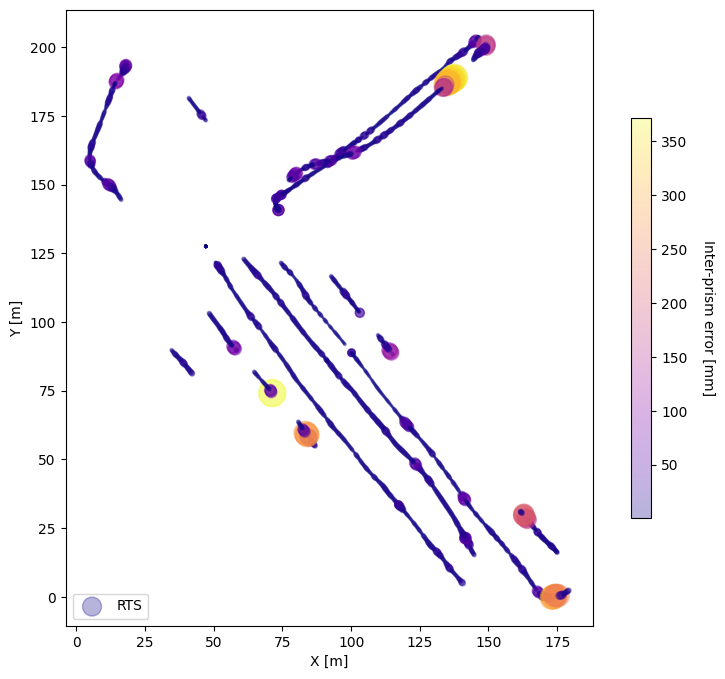

In [30]:
import matplotlib.colors as colors
plt.figure(figsize=(10,8))
scale_factor = 1

plt.scatter(df_rts['X']-X_origin, df_rts['Y']-Y_origin, cmap = 'plasma', c=df_rts['Inter_prism'], label='RTS', s=scale_factor * df_rts['Inter_prism'], alpha=0.3)

plt.gca().set_aspect('equal')
plt.legend(loc = 'lower left')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

colorbar = plt.colorbar(shrink=0.65)
colorbar.set_label('Inter-prism error [mm]', rotation=270, labelpad=20)

## 6.2 inter-gps

In [31]:
df_gps_1 = pd.read_csv(path + "gps_data/rover_1_raw.csv", names=['Point ID','Easting','Northing','Elevation','H. Precision','V. Precision','PDOP','Sats','Date','Time'], delimiter= ';', skiprows=[0])
df_gps_2 = pd.read_csv(path + "gps_data/rover_2_raw.csv", names=['Point ID','Easting','Northing','Elevation','H. Precision','V. Precision','PDOP','Sats','Date','Time'], delimiter= ';', skiprows=[0])
df_gps_3 = pd.read_csv(path + "gps_data/rover_3_raw.csv", names=['Point ID','Easting','Northing','Elevation','H. Precision','V. Precision','PDOP','Sats','Date','Time'], delimiter= ';', skiprows=[0])

In [32]:
def convert_to_unix_timestamp(df):
    df["Datetime"] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y-%m-%d %H:%M:%S')
    df['Timestamp'] = df["Datetime"].values.astype(np.int64) // 10 ** 9
    df.drop(["Date", "Time"], axis=1, inplace=True)
    return df

In [33]:
# df_gps_1['Timestamp'] = df_gps_1["Timestamp"].values.astype(np.int64) // (1*10 ** 9) # Convert to Unix Timestamp
df_gps_1 = convert_to_unix_timestamp(df_gps_1)
df_gps_2 = convert_to_unix_timestamp(df_gps_2)
df_gps_3 = convert_to_unix_timestamp(df_gps_3)

In [34]:
# xs_gps = [None] * len(traj_common['Timestamp'])
# print(len(traj_common['Timestamp']))
# for i in range(0,len(traj_common['Timestamp'])):
#     try:
#         if traj_common['Timestamp'][i] != 'None' :
#             out1 = next(iter(np.where(df_gps_1['Timestamp'] == traj_common['Timestamp'][i])[0]), 'Nan')
#             out2 = next(iter(np.where(df_gps_2['Timestamp'] == traj_common['Timestamp'][i])[0]), 'Nan')
#             out3 = next(iter(np.where(df_gps_3['Timestamp'] == traj_common['Timestamp'][i])[0]), 'Nan')
#             if out1!='Nan' and out2!='Nan' and out3!='Nan':
#                 point_1 = np.array([np.float(df_gps_1['Easting'][out1]),np.float(df_gps_1['Northing'][out1]),np.float(df_gps_1['Elevation'][out1])])
#                 point_2 = np.array([np.float(df_gps_2['Easting'][out2]),np.float(df_gps_2['Northing'][out2]),np.float(df_gps_2['Elevation'][out2])])
#                 point_3 = np.array([np.float(df_gps_3['Easting'][out3]),np.float(df_gps_3['Northing'][out3]),np.float(df_gps_3['Elevation'][out3])])
#                 d12_gps = 1000*abs(np.linalg.norm(point_1-point_2)-extrinsic_calibration_results[3])
#                 d13_gps = 1000*abs(np.linalg.norm(point_1-point_3)-extrinsic_calibration_results[4])
#                 d23_gps = 1000*abs(np.linalg.norm(point_2-point_3)-extrinsic_calibration_results[5])
#                 if np.mean([d12_gps,d13_gps,d23_gps])<10000:
#                     xs_gps[i]= np.mean([d12_gps,d13_gps,d23_gps])
#     except:
#         print('error')
# traj_common['Inter_gps'] = xs_gps

In [35]:
def calculate_gps_interpolation(df_gps, df_gps_1, df_gps_2, df_gps_3, extrinsic_calibration_results):
    xs_gps = []
    for timestamp in df_gps['Timestamp']:
        if timestamp != 'None':
            mask_1 = df_gps_1['Timestamp'] == timestamp
            mask_2 = df_gps_2['Timestamp'] == timestamp
            mask_3 = df_gps_3['Timestamp'] == timestamp
            
            if mask_1.any() and mask_2.any() and mask_3.any():
                point_1 = df_gps_1.loc[mask_1, ['Easting', 'Northing', 'Elevation']].values[0]
                point_2 = df_gps_2.loc[mask_2, ['Easting', 'Northing', 'Elevation']].values[0]
                point_3 = df_gps_3.loc[mask_3, ['Easting', 'Northing', 'Elevation']].values[0]
                
                d12_gps = 1000 * abs(np.linalg.norm(point_1 - point_2) - extrinsic_calibration_results[3])
                d13_gps = 1000 * abs(np.linalg.norm(point_1 - point_3) - extrinsic_calibration_results[4])
                d23_gps = 1000 * abs(np.linalg.norm(point_2 - point_3) - extrinsic_calibration_results[5])
                
                if np.mean([d12_gps, d13_gps, d23_gps]) < 10000:
                    xs_gps.append(np.mean([d12_gps, d13_gps, d23_gps]))
                else:
                    xs_gps.append(None)
            else:
                xs_gps.append(None)
        else:
            xs_gps.append(None)
    df_gps['Inter_gps'] = xs_gps
    return df_gps

df_gps = calculate_gps_interpolation(df_gps, df_gps_1, df_gps_2, df_gps_3, extrinsic_calibration_results)
# print(traj_common['Inter_gps'][:])


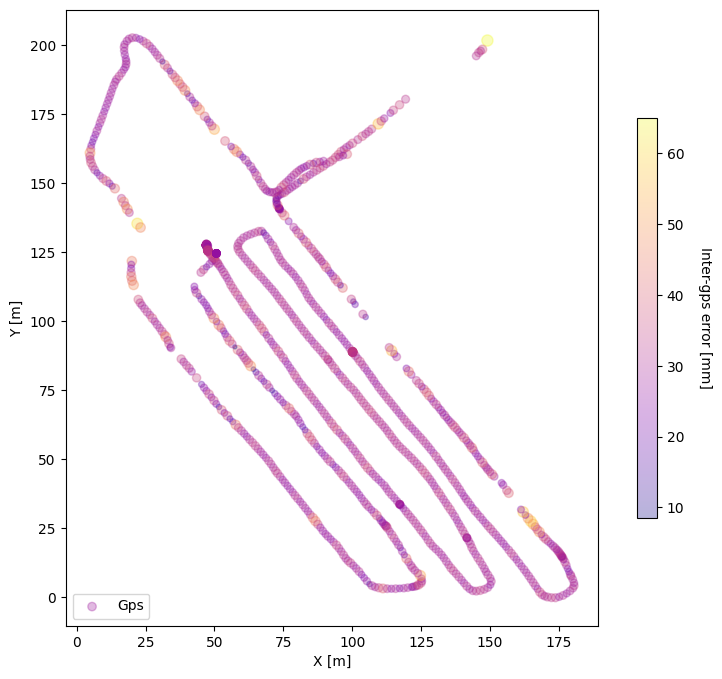

In [36]:
import matplotlib.colors as colors
plt.figure(figsize=(10,8))
scale_factor = 1
plt.scatter(df_gps['X']-X_origin, df_gps['Y']-Y_origin, cmap = 'plasma', c=df_gps['Inter_gps'], label='Gps', s= scale_factor * df_gps['Inter_gps'], alpha=0.3)
# plt.scatter(traj_common['X_gps'] - X_origin, traj_common['Y_gps'] - Y_origin, cmap = 'plasma', c=traj_common['Inter_gps'], label='Gps common', s= scale_factor * traj_common['Inter_gps'], alpha=0.3)
plt.gca().set_aspect('equal')
plt.legend(loc = 'lower left')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

colorbar = plt.colorbar(shrink=0.65)
colorbar.set_label('Inter-gps error [mm]', rotation=270, labelpad=20)
#colorbar.set_ticks([min(traj_common['Inter-gps']), max(traj_common['Inter-gps'])])

## Figure : inter-prism & inter-gps

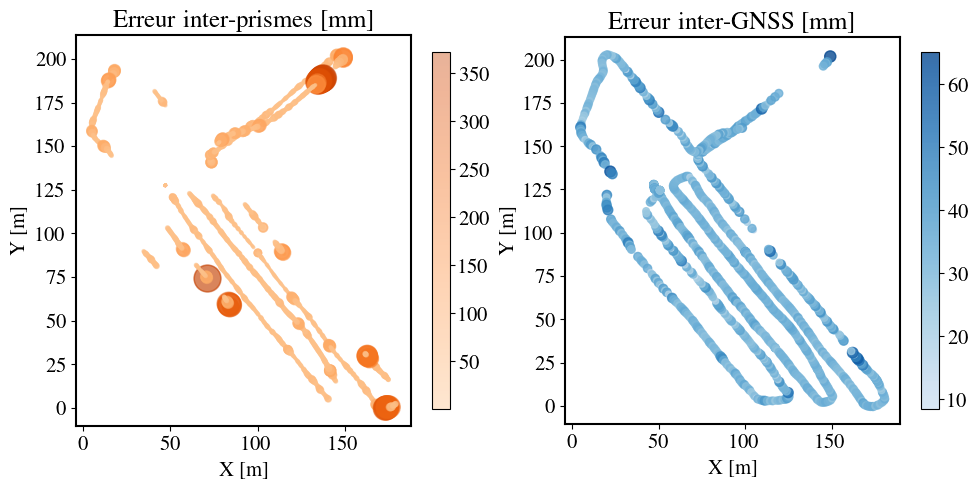

In [74]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)
plt.rcParams.update({'font.size': 15})
font_size = 15

def plot_scatter_with_colorbar(ax, x, y, c, cmap, alpha, title, xlabel, ylabel, name, s):
    if cmap == 'Oranges':
        hsv_modified = cm.get_cmap(cmap, 256)
        newcmp = ListedColormap(hsv_modified(np.linspace(0.3, 0.8, 256)))
    else:
        hsv_modified = cm.get_cmap(cmap, 256)
        newcmp = ListedColormap(hsv_modified(np.linspace(0.2, 0.9, 256)))
    im = ax.scatter(x, y, cmap=newcmp, c=c, s=s, alpha=alpha)
    ax.set_title(title)
    ax.set_xlabel(xlabel, labelpad=5)
    ax.set_ylabel(ylabel, labelpad=5)
    ax.set_aspect('equal')
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    # cbar.set_label('Erreur inter-' + name + '  [mm]', rotation=270, labelpad=20, fontsize = font_size)

# fig, ax = plt.subplots(figsize=(15, 6), ncols=2, nrows=1)
fig, ax = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)

plot_scatter_with_colorbar(ax[0], df_rts['X'] - X_origin, df_rts['Y'] - Y_origin, df_rts['Inter_prism'], 'Oranges', 0.4,'Erreur inter-prismes [mm]', 'X [m]', 'Y [m]', 'prismes', df_rts['Inter_prism'])
plot_scatter_with_colorbar(ax[1], df_gps['X'] - X_origin, df_gps['Y'] - Y_origin, df_gps['Inter_gps'], 'Blues', 0.8,'Erreur inter-GNSS [mm]', 'X [m]', 'Y [m]', 'GNSS', df_gps['Inter_gps'])
plt.tight_layout()

for axis in ['top', 'bottom', 'left', 'right']:
    ax[0].spines[axis].set_linewidth(1.5)
    ax[1].spines[axis].set_linewidth(1.5)

fig.set_size_inches(10, 5)
plt.savefig(os.path.expanduser('~') + '/Master_thesis/Figures/inter_prism_gps.pdf')

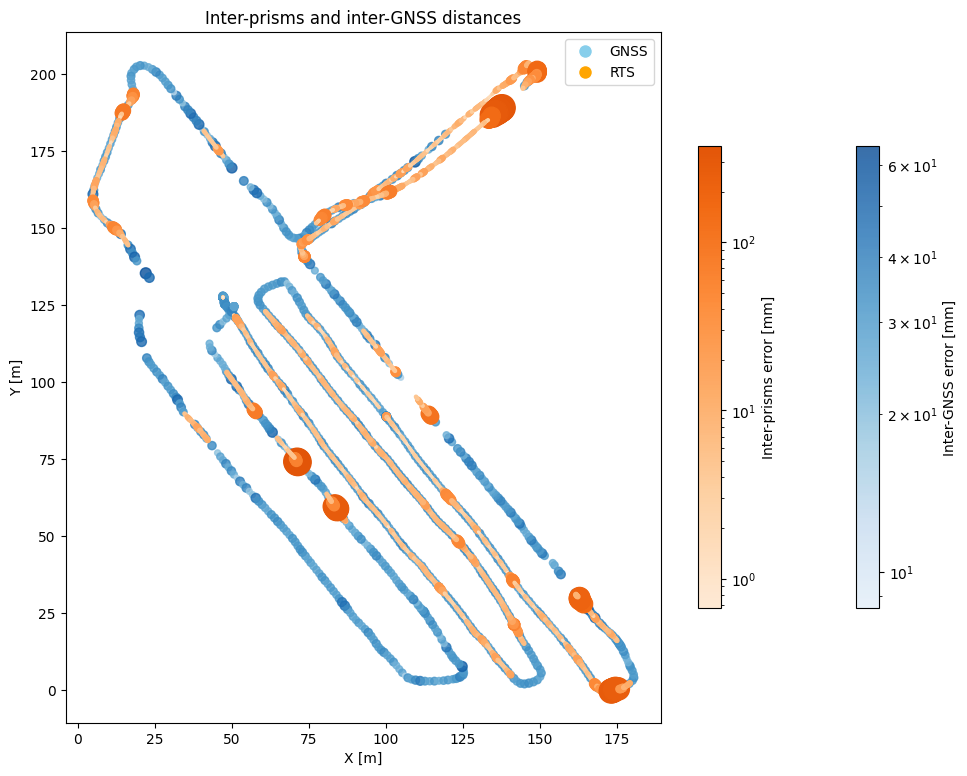

In [26]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(12, 12))

hsv_oranges = cm.get_cmap('Oranges', 256)
hsv_blues = cm.get_cmap('Blues', 256)
oranges = ListedColormap(hsv_oranges(np.linspace(0.1, 0.7, 256)))
blues = ListedColormap(hsv_blues(np.linspace(0.1, 0.9, 256)))

# Define the log norm for the color scale
log_norm_gps = LogNorm(vmin=df_gps['Inter_gps'].min(), vmax=df_gps['Inter_gps'].max())
log_norm_rts = LogNorm(vmin=df_rts['Inter_prism'].min(), vmax=df_rts['Inter_prism'].max())

# Plot the scatter plots with log scale color bars
sc2 = plt.scatter(df_gps['X'] - X_origin, df_gps['Y'] - Y_origin, c=df_gps['Inter_gps'], cmap=blues, label='GPS', s=df_gps['Inter_gps'], alpha=0.8, norm=log_norm_gps)
plt.colorbar(sc2, label='Inter-GNSS error [mm]', shrink=0.5)

sc1 = plt.scatter(df_rts['X'] - X_origin, df_rts['Y'] - Y_origin, c=df_rts['Inter_prism'], cmap=oranges, label='RTS', s=df_rts['Inter_prism'], norm=log_norm_rts)
plt.colorbar(sc1, label='Inter-prisms error [mm]', shrink=0.5)


legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='GNSS', markerfacecolor='skyblue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='RTS', markerfacecolor='orange', markersize=10),
]
plt.legend(handles=legend_elements, loc='upper right')


plt.gca().set_aspect('equal')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Inter-prisms and inter-GNSS distances')
plt.savefig('/Users/effiedaum/Master_thesis/Workshop IROS23/distances.pdf', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Inter-prism and Inter-GPS Distances')

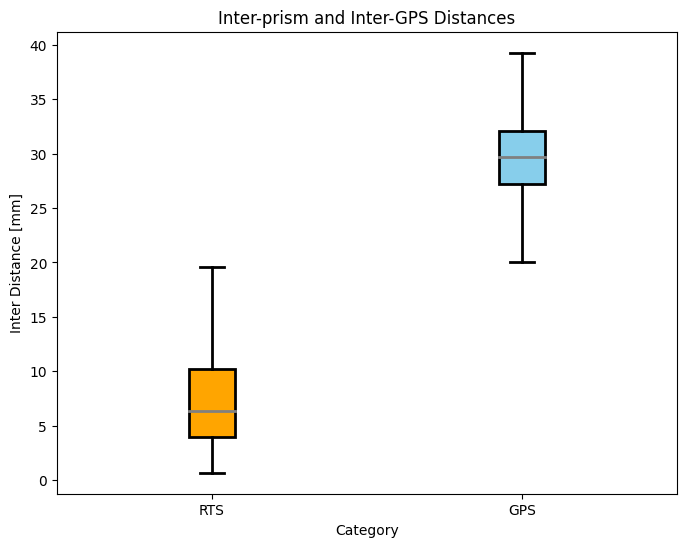

In [27]:
data = [df_rts['Inter_prism'], df_gps['Inter_gps']]
labels = ['RTS', 'GPS']

# Create the boxplot without outliers
plt.figure(figsize=(8, 6))
box = plt.boxplot(data, labels=labels, showfliers=False, vert=True, patch_artist=True)

# Set the color of the boxes and medians
box['boxes'][0].set(facecolor='orange', linewidth=2)  # Set the linewidth to 2
box['boxes'][1].set(facecolor='skyblue', linewidth=2) # Set the linewidth to 2
box['medians'][0].set_color('grey')
box['medians'][1].set_color('grey')

# Increase the linewidth of the whiskers and caps
for whisker in box['whiskers']:
    whisker.set_linewidth(2)  # Set the linewidth to 2

for cap in box['caps']:
    cap.set_linewidth(2)  # Set the linewidth to 2

# Increase the linewidth of the medians
box['medians'][0].set_linewidth(2)  # Set the linewidth to 2
box['medians'][1].set_linewidth(2)  # Set the linewidth to 2

plt.xlabel('Category')
plt.ylabel('Inter Distance [mm]')
plt.title('Inter-prism and Inter-GPS Distances')

# 7. Save error inter-prism and inter-gps in vtk

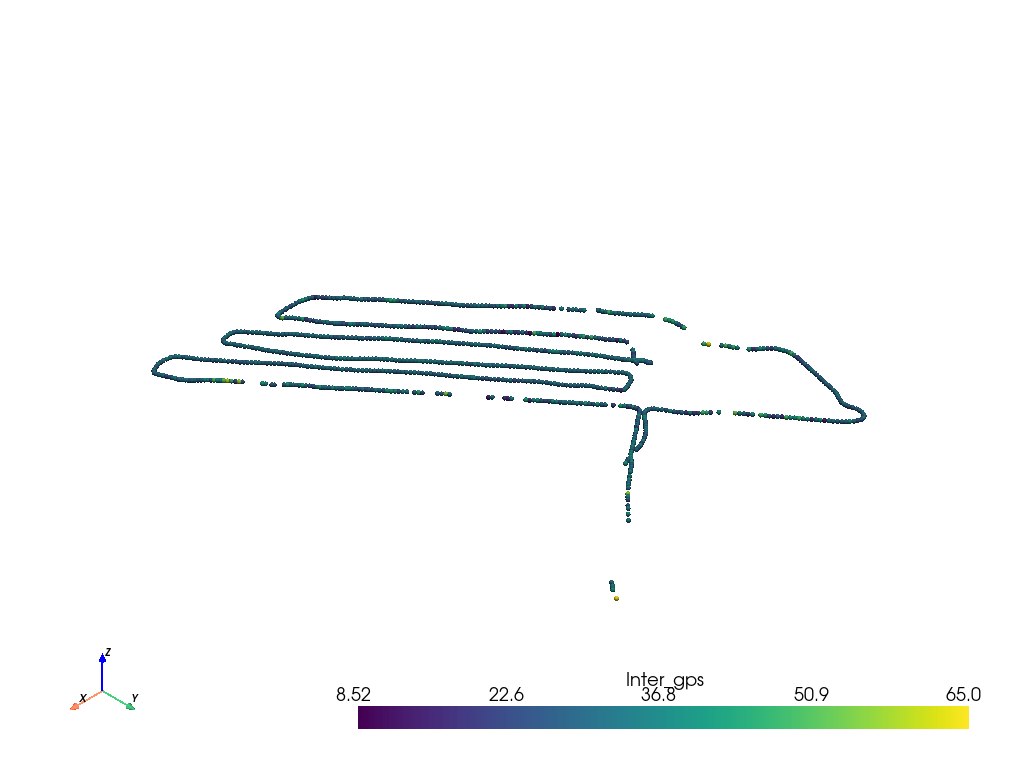

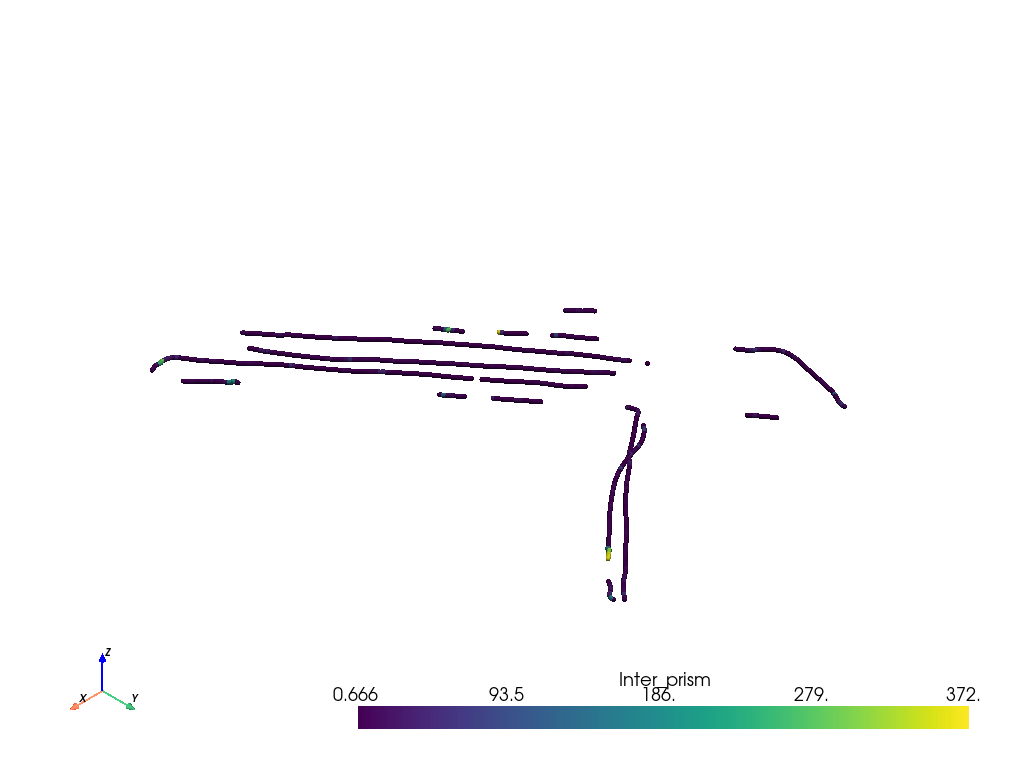

In [28]:
#import required packages
import itertools
import numpy as np
import pyvista as pv
import math

pointSec = []
inter_gps = []
for index, valuesx in df_gps.iterrows():
    if df_gps.loc[index].Inter_gps!='None' and math.isnan(df_gps.loc[index].Inter_gps)!=True:
        x, y, z = df_gps.loc[index].X, df_gps.loc[index].Y, df_gps.loc[index].Z
        inter_gps.append(df_gps.loc[index].Inter_gps)
        pointSec.append([x- X_origin,y- Y_origin,z- Z_origin])
    
pointSec = np.array(pointSec)
inter_gps = np.array(inter_gps)
point_cloud = pv.PolyData(pointSec)
# data = points[:,-1]
point_cloud["Inter_gps"]=inter_gps
point_cloud.plot(render_points_as_spheres=True)
point_cloud.save(os.path.expanduser('~') + '/' + date + '_gps_traj.vtk',binary=False)

pointSec = []
inter_rts = []
for index, valuesx in df_rts.iterrows():
    if df_rts.loc[index].Inter_prism!='None' and math.isnan(df_rts.loc[index].Inter_prism)!=True:
        x, y, z = df_rts.loc[index].X, df_rts.loc[index].Y, df_rts.loc[index].Z
        inter_rts.append(df_rts.loc[index].Inter_prism)
        pointSec.append([x- X_origin,y- Y_origin,z- Z_origin])
    
pointSec = np.array(pointSec)
inter_rts = np.array(inter_rts)
point_cloud = pv.PolyData(pointSec)
# data = points[:,-1]
point_cloud["Inter_prism"]=inter_rts
point_cloud.plot(render_points_as_spheres=True)
point_cloud.save(os.path.expanduser('~') + '/' + date + '_rts_traj.vtk',binary=False)

# 8. Read error inter-prism and inter-gps in vtk for the two experiments


In [29]:
traj_rts_20230725_1 = pv.read(os.path.expanduser('~') + '/20230725-1_rts_traj.vtk')
traj_rts_20230725_2 = pv.read(os.path.expanduser('~') + '/20230725-2_rts_traj.vtk')
traj_gps_20230725_1 = pv.read(os.path.expanduser('~') + '/20230725-1_gps_traj.vtk')
traj_gps_20230725_2 = pv.read(os.path.expanduser('~') + '/20230725-2_gps_traj.vtk')

point_1_rts = np.array(traj_rts_20230725_1.points)
point_2_rts = np.array(traj_rts_20230725_2.points)
inter_prism_1 = np.array(traj_rts_20230725_1['Inter_prism'])
inter_prism_2 = np.array(traj_rts_20230725_2['Inter_prism'])

point_1_gps = np.array(traj_gps_20230725_1.points)
point_2_gps = np.array(traj_gps_20230725_2.points)
inter_gps_1 = np.array(traj_gps_20230725_1['Inter_gps'])
inter_gps_2 = np.array(traj_gps_20230725_2['Inter_gps'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Rts common between experiment 1 and 2')

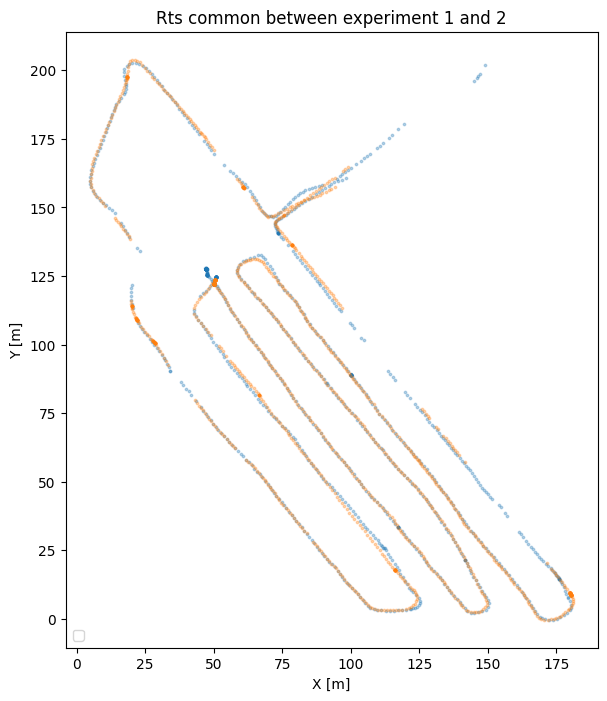

In [30]:
plt.figure(figsize=(10,8))

plt.scatter(point_1_gps[:,0], point_1_gps[:,1], s=3, alpha=0.3)
plt.scatter(point_2_gps[:,0], point_2_gps[:,1], s=3, alpha=0.3)

plt.gca().set_aspect('equal')
plt.legend(loc = 'lower left')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Rts common between experiment 1 and 2')

In [31]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=1, radius=1)
neigh.fit(point_2_rts)

index_tupple = []
num = 0
for i in range(0,len(point_1_rts)):
    dist, index = neigh.kneighbors([point_1_rts[i]], 1, return_distance=True)
    if dist[0][0]<2: # 2 meter
        index_tupple.append([num, index[0][0]])
    num = num+1
    
diff_error = []
point_1_final = []
for i in index_tupple:
    diff_error.append([i[0], abs(inter_prism_1[i[0]]-inter_prism_2[i[1]])])
    point_1_final.append(point_1_rts[i[0]])
diff_error_rts = np.array(diff_error)
point_1_final_rts = np.array(point_1_final)

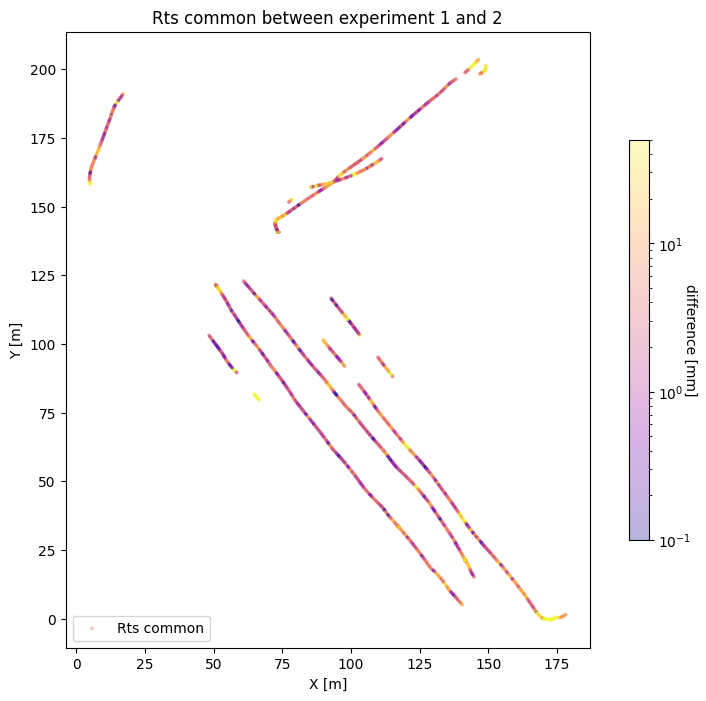

In [32]:
import matplotlib.colors as colors
plt.figure(figsize=(10,8))

plt.scatter(point_1_final_rts[:,0], point_1_final_rts[:,1], cmap = 'plasma', norm=colors.LogNorm(vmin=0.1, vmax=50), c=diff_error_rts[:,1], label='Rts common', s=3, alpha=0.3)

plt.gca().set_aspect('equal')
plt.legend(loc = 'lower left')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Rts common between experiment 1 and 2')

colorbar = plt.colorbar(shrink=0.65)
colorbar.set_label('difference [mm]', rotation=270)

In [33]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=1, radius=1)
neigh.fit(point_2_gps)

index_tupple = []
num = 0
for i in range(0,len(point_1_gps)):
    dist, index = neigh.kneighbors([point_1_gps[i]], 1, return_distance=True)
    if dist[0][0]<2: # 2 meter
        index_tupple.append([num, index[0][0]])
    num = num+1
    
diff_error = []
point_1_final = []
for i in index_tupple:
    diff_error.append([i[0], abs(inter_gps_1[i[0]]-inter_gps_2[i[1]])])
    point_1_final.append(point_1_gps[i[0]])
diff_error_gps = np.array(diff_error)
point_1_final_gps = np.array(point_1_final)

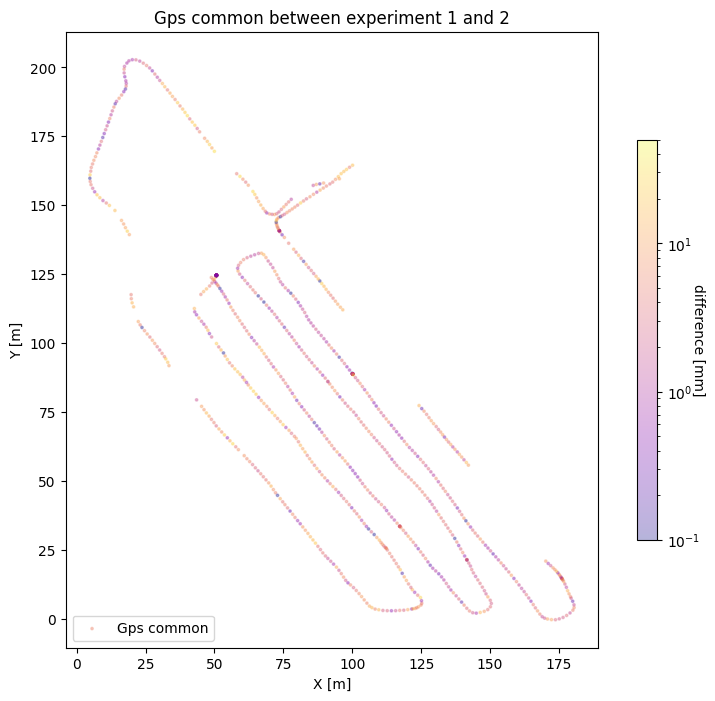

In [34]:
import matplotlib.colors as colors
plt.figure(figsize=(10,8))

plt.scatter(point_1_final_gps[:,0], point_1_final_gps[:,1], cmap = 'plasma', norm=colors.LogNorm(vmin=0.1, vmax=50), c=diff_error_gps[:,1], label='Gps common', s=3, alpha=0.3)

plt.gca().set_aspect('equal')
plt.legend(loc = 'lower left')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Gps common between experiment 1 and 2')
colorbar = plt.colorbar(shrink=0.65)
colorbar.set_label('difference [mm]', rotation=270)

(-10.754613582597, 216.69334459345703)

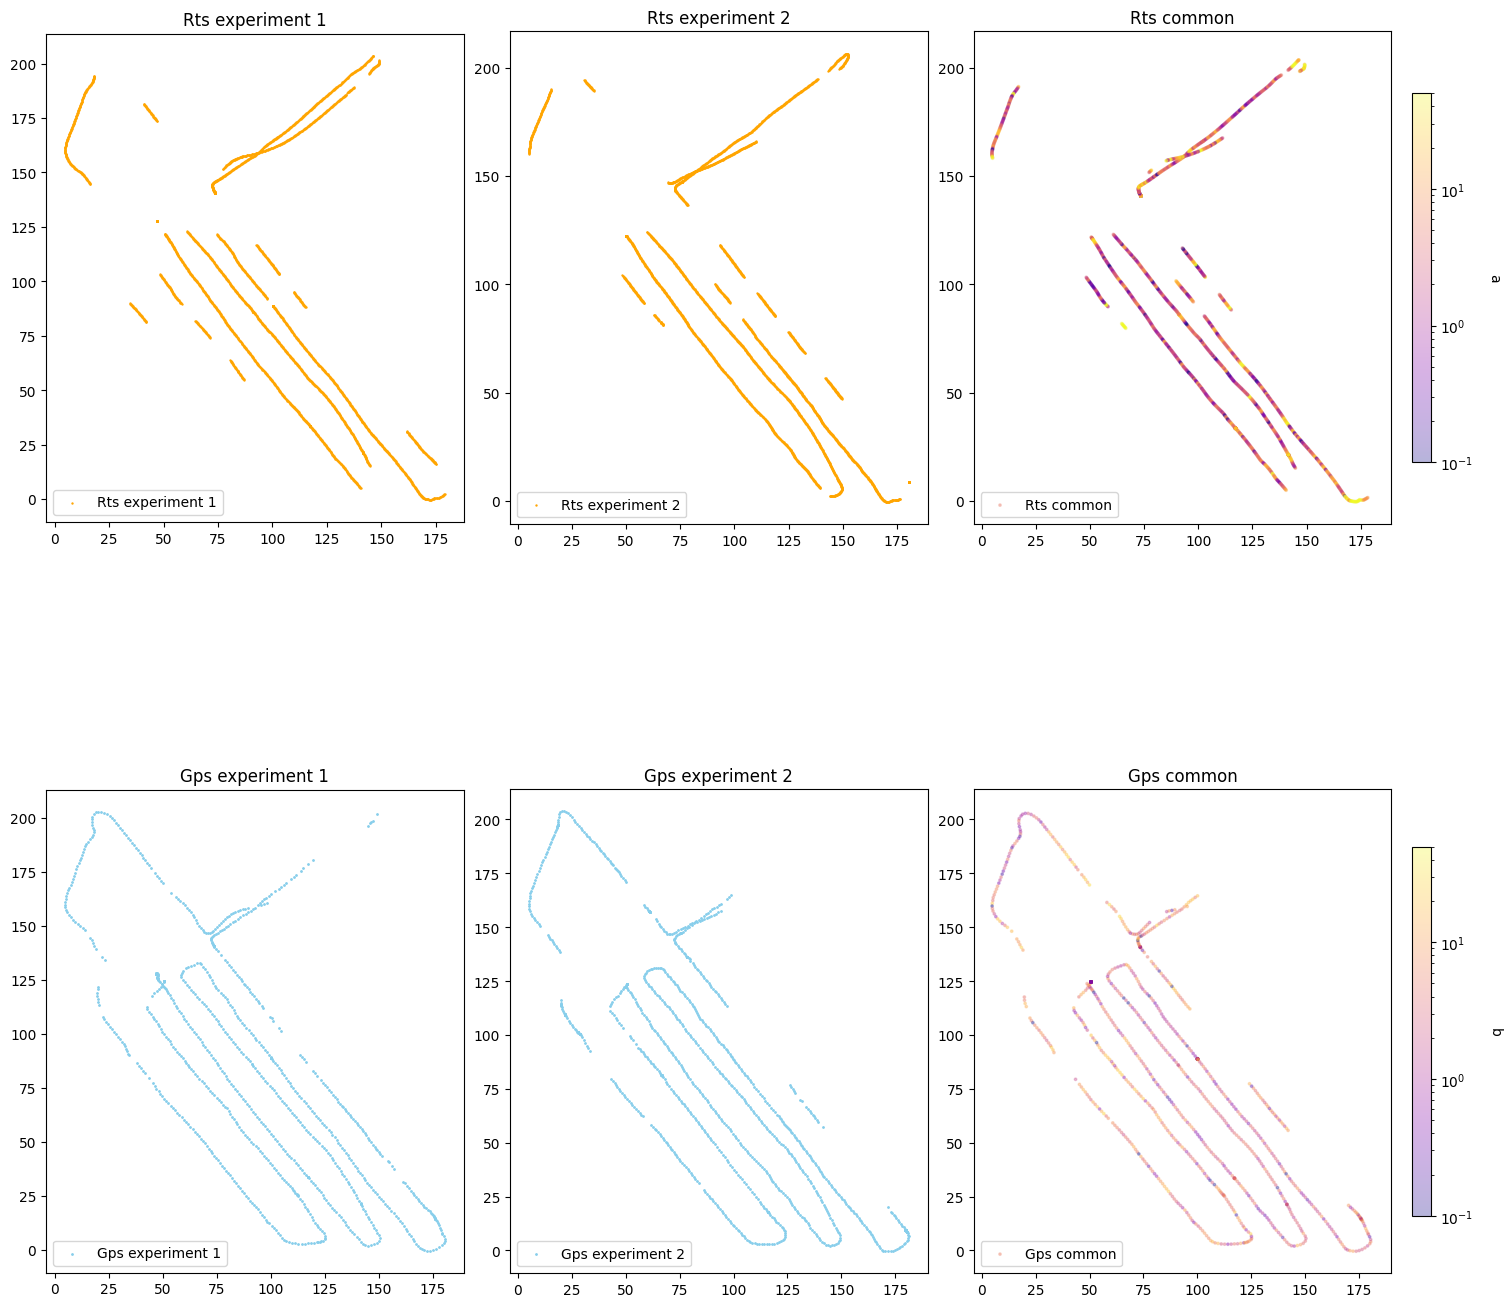

In [35]:
fig, ax = plt.subplots(figsize=(15, 15), ncols=3, nrows=2, constrained_layout=True)

ax[0][0].scatter(point_1_rts[:,0], point_1_rts[:,1], c='orange', s=1/2, label='Rts experiment 1')
ax[0][1].scatter(point_2_rts[:,0], point_2_rts[:,1], c='orange', s=1/2, label='Rts experiment 2')
sc1 = ax[0][2].scatter(point_1_final_rts[:,0], point_1_final_rts[:,1], cmap = 'plasma', norm=colors.LogNorm(vmin=0.1, vmax=50), c=diff_error_rts[:,1], label='Rts common', s=3, alpha=0.3)

ax[1][0].scatter(point_1_gps[:,0], point_1_gps[:,1], c='skyblue', s=1, label='Gps experiment 1')
ax[1][1].scatter(point_2_gps[:,0], point_2_gps[:,1], c='skyblue', s=1, label = 'Gps experiment 2')
sc2 = ax[1][2].scatter(point_1_final_gps[:,0], point_1_final_gps[:,1], cmap = 'plasma', norm=colors.LogNorm(vmin=0.1, vmax=50), c=diff_error_gps[:,1], label='Gps common', s=3, alpha=0.3)

cbar1 = plt.colorbar(sc1, ax=ax[0][2], shrink=0.5)
cbar1.set_label('a', rotation=270, labelpad=20)

cbar2 = plt.colorbar(sc2, ax=ax[1][2], shrink=0.5)
cbar2.set_label('b', rotation=270, labelpad=20)

ax[0][0].set_title('Rts experiment 1')
ax[0][1].set_title('Rts experiment 2')
ax[0][2].set_title('Rts common')

ax[1][0].set_title('Gps experiment 1')
ax[1][1].set_title('Gps experiment 2')
ax[1][2].set_title('Gps common')

ax[0][0].set_aspect('equal')
ax[0][1].set_aspect('equal')
ax[0][2].set_aspect('equal')

ax[1][0].set_aspect('equal')
ax[1][1].set_aspect('equal')
ax[1][2].set_aspect('equal')

ax[0][0].legend(loc = 'lower left')
ax[0][1].legend(loc = 'lower left')
ax[0][2].legend(loc = 'lower left')

ax[1][0].legend(loc = 'lower left')
ax[1][1].legend(loc = 'lower left')
ax[1][2].legend(loc = 'lower left')
ax[1][2].set_xlim(ax[1][1].get_xlim()[0], ax[1][1].get_xlim()[1])
ax[1][2].set_ylim(ax[1][1].get_ylim()[0], ax[1][1].get_ylim()[1])
ax[0][2].set_xlim(ax[0][1].get_xlim()[0], ax[0][1].get_xlim()[1])
ax[0][2].set_ylim(ax[0][1].get_ylim()[0], ax[0][1].get_ylim()[1])



## Figure : reproductibility & precision

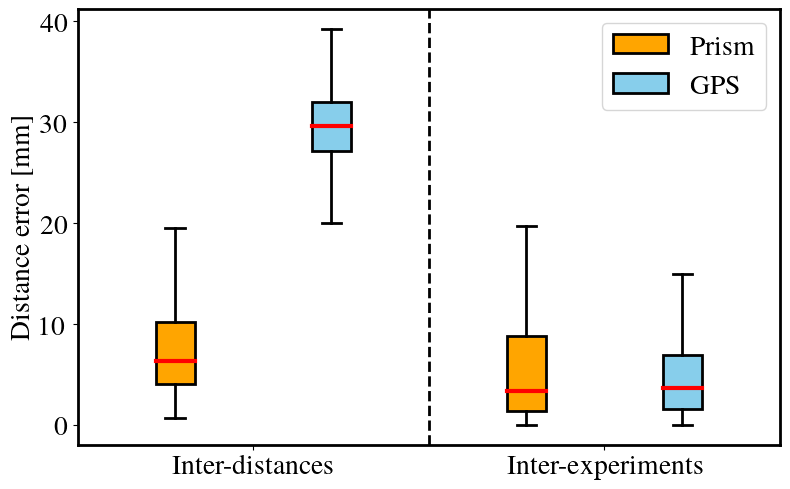

In [36]:
import matplotlib.patches as mpatches

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
font_size = 20

width = 3.487
height = width / 1.618

# Data and labels for the first boxplot
data1 = [df_rts['Inter_prism'], df_gps['Inter_gps']]
labels1 = ['Inter-prism', 'Inter-gps']
title1 = 'Inter-distances error'

# Data and labels for the second boxplot
data2 = [diff_error_rts[:, 1], diff_error_gps[:, 1]]
labels2 = ['Inter-experiments', 'Inter-experiments']
title2 = 'Inter-experiment error'

tickslabs = ["Inter-distances", "Inter-experiments"]

# Create the figure and axes
plt.figure(figsize=(8, 5))
ax = plt.gca()

# Combine the data and labels for the boxplots
data = data1 + data2
labels = labels1 + labels2

# Plot the combined boxplot
box = ax.boxplot(data, labels=labels, showfliers=False, vert=True, patch_artist=True, widths=0.2, positions=[1, 1.8, 2.8, 3.6], manage_ticks=True)
# Set the color of the boxes and medians
box['boxes'][0].set(facecolor='orange', linewidth=2)
box['boxes'][1].set(facecolor='skyblue', linewidth=2)
box['boxes'][2].set(facecolor='orange', linewidth=2)
box['boxes'][3].set(facecolor='skyblue', linewidth=2)

# Set the color of the medians
box['medians'][0].set_color('red')
box['medians'][1].set_color('red')
box['medians'][2].set_color('red')
box['medians'][3].set_color('red')

# Increase the linewidth of the whiskers and caps
for whisker in box['whiskers']:
    whisker.set_linewidth(2)

for cap in box['caps']:
    cap.set_linewidth(2)

# Increase the linewidth of the medians
for median in box['medians']:
    median.set_linewidth(3)

# Increase the linewidth of the axes spines (borders)
for spine in ax.spines.values():
    spine.set_linewidth(2)

legend_handles = [
    mpatches.Patch(facecolor='orange', label='Prism', edgecolor='black', linewidth=2),
    mpatches.Patch(facecolor='skyblue', label='GPS', edgecolor='black', linewidth=2)
]
ax.legend(handles=legend_handles, fontsize=font_size)

# Add a dashed line in the middle to separate the two boxplots
ax.axvline(x=2.3, color='black', linestyle='--', linewidth=2)

# plt.xlabel('Distance Type', fontsize=font_size)
plt.ylabel('Distance error [mm]', fontsize=font_size)

ax.tick_params(axis="x", which="major", labelsize=font_size)
plt.xticks([1.4, 3.2], tickslabs, fontsize=font_size)

plt.tight_layout()

plt.savefig(os.path.expanduser('~') + '/boxplot_inter.png', bbox_inches='tight')


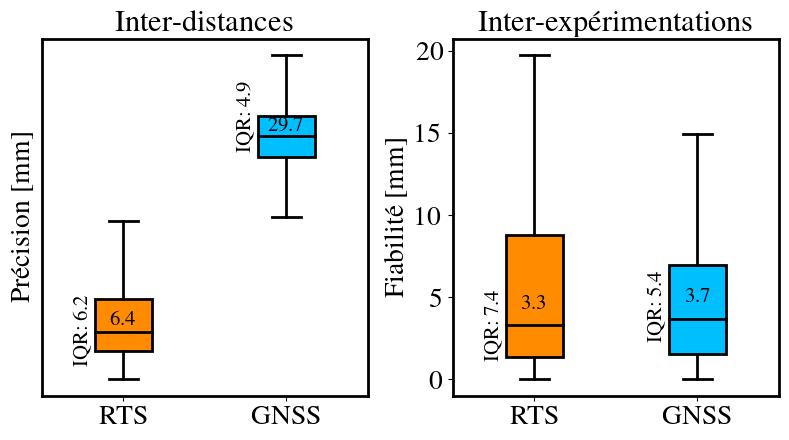

In [38]:
data1 = [df_rts['Inter_prism'], df_gps['Inter_gps']]
data2 = [diff_error_rts[:, 1], diff_error_gps[:, 1]]

data = data1+data2

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=10)
font_size = 20

fig, ax = plt.subplots(figsize = (7.5,4.5) ,ncols=2, nrows=1)
fig.subplots_adjust(left=.13, bottom=.13, right=.99, top=.99,wspace=3)

ax[0].set_alpha(0.2)
ax[1].set_alpha(0.2)

box1 = ax[0].boxplot(data1, notch=False, patch_artist=True, vert = 1, showfliers=False, showmeans=False, widths=0.35)
box2 = ax[1].boxplot(data2, notch=False, patch_artist=True, vert = 1, showfliers=False, showmeans=False, widths=0.35)

box1['boxes'][0].set(facecolor='darkorange', linewidth=2)
box1['boxes'][1].set(facecolor='deepskyblue', linewidth=2)
box2['boxes'][0].set(facecolor='darkorange', linewidth=2)
box2['boxes'][1].set(facecolor='deepskyblue', linewidth=2)

for median in box1['medians']:
    median.set_color('black')
for median in box2['medians']:
    median.set_color('black')

for median in box1['medians']:
    median.set_linewidth(2)
for median in box2['medians']:
    median.set_linewidth(2)

for cap in box1['caps']:
    cap.set_linewidth(2)
for cap in box2['caps']:
    cap.set_linewidth(2)

for whisker in box1['whiskers']:
    whisker.set_linewidth(2)
for whisker in box2['whiskers']:
    whisker.set_linewidth(2)

for spine in ax[0].spines.values():
    spine.set_linewidth(2)
for spine in ax[1].spines.values():
    spine.set_linewidth(2)

font_size_numbers = 15


ax[0].text(1, np.round(np.median(data1[0]),1) +0.7, str(np.round(np.median(data1[0]),1)), horizontalalignment='center',fontsize = font_size_numbers)
ax[0].text(2, np.round(np.median(data1[1]),1) +0.5, str(np.round(np.median(data1[1]),1)), horizontalalignment='center',fontsize = font_size_numbers)
ax[1].text(1, np.round(np.median(data2[0]),1) +1, str(np.round(np.median(data2[0]),1)), horizontalalignment='center',fontsize = font_size_numbers)
ax[1].text(2, np.round(np.median(data2[1]),1) +1, str(np.round(np.median(data2[1]),1)), horizontalalignment='center',fontsize = font_size_numbers)

ax[0].text(0.75, np.round(np.percentile(data1[0], 5, interpolation='midpoint'),1)+1, 'IQR: '+str(np.round(np.percentile(data1[0], 75, interpolation='midpoint')-np.percentile(data1[0], 25, interpolation='midpoint'),1)), horizontalalignment='center',fontsize = font_size_numbers, rotation=90)
ax[0].text(1.75, np.round(np.percentile(data1[1], 25, interpolation='midpoint'),1)+1, 'IQR: '+str(np.round(np.percentile(data1[1], 75, interpolation='midpoint')-np.percentile(data1[1], 25, interpolation='midpoint'),1)), horizontalalignment='center',fontsize = font_size_numbers, rotation=90)
ax[1].text(0.75, np.round(np.percentile(data2[0], 5, interpolation='midpoint'),1)+1, 'IQR: '+str(np.round(np.percentile(data2[0], 75, interpolation='midpoint')-np.percentile(data2[0], 25, interpolation='midpoint'),1)), horizontalalignment='center',fontsize = font_size_numbers, rotation=90)
ax[1].text(1.75, np.round(np.percentile(data2[1], 25, interpolation='midpoint'),1)+1, 'IQR: '+str(np.round(np.percentile(data2[1], 75, interpolation='midpoint')-np.percentile(data2[1], 25, interpolation='midpoint'),1)), horizontalalignment='center',fontsize = font_size_numbers, rotation=90)

ax[0].set_title('Inter-distances', fontsize=22)
ax[1].set_title('Inter-expérimentations', fontsize=22)


ax[0].set_xticklabels(['RTS','GNSS'], fontsize=font_size)
ax[1].set_xticklabels(['RTS','GNSS'], fontsize=font_size)
ax[0].set_ylabel('Précision [mm]',fontsize = font_size, labelpad=5)
ax[1].set_ylabel('Fiabilité [mm]',fontsize = font_size, labelpad=5)


ax[0].tick_params(axis='y', which='major', labelsize=font_size)
ax[0].get_yaxis().set_ticks([])
ax[1].tick_params(axis='y', which='major', labelsize=font_size)

# ax[0].set_aspect(0.08)
# ax[1].set_aspect(0.08)
# ax[0].set_yscale('log')
# ax[1].set_yscale('log')
# ax[0].set_ylim([0.1, 1000])
# ax[1].set_ylim([0.1, 1000])

fig.set_size_inches(8, 4.5)
plt.tight_layout()
plt.savefig(os.path.expanduser('~') + '/boxplot_inter.pdf', bbox_inches='tight')

# Save GNSS inter-experiments results in .vtk

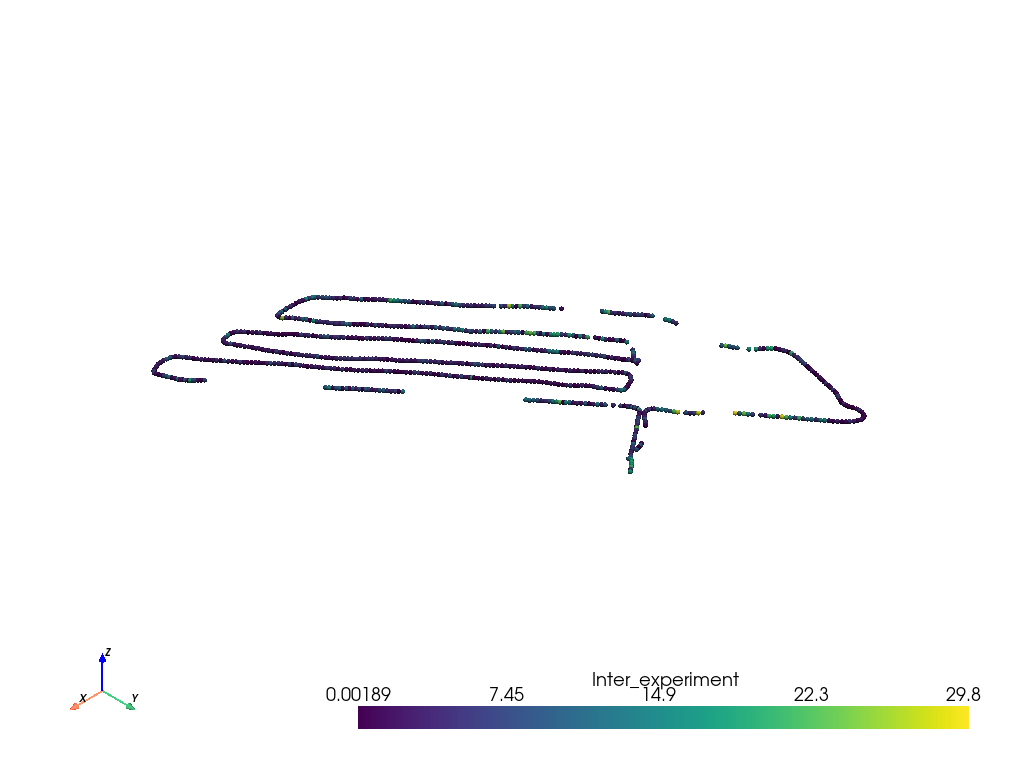

In [204]:
#import required packages
import itertools
import numpy as np
import pyvista as pv
import math

pointSec = np.array(pointSec)
inter_gps = np.array(inter_gps)
point_cloud = pv.PolyData(point_1_final_gps)
# data = points[:,-1]
point_cloud["Inter_experiment"]=diff_error_gps[:,1]
point_cloud.plot(render_points_as_spheres=True)
point_cloud.save(os.path.expanduser('~') + '/' + date + '_gps_diff.vtk',binary=False)


# 8. Other datasets for RTS and GNSS
## 8.1 GNSS process

In [205]:
# Path of output
path_20220224 = "../data/20220224/"
path_20220307 = "../data/20220307/"
path_20220314 = "../data/20220314/"
path_20220316 = "../data/20220316/"
path_20220525 = "../data/20220525-1/"
path_20220622 = "../data/20220622-1/"
path_20220630 = "../data/20220630-1/"
path_20220711 = "../data/20220711-1/"

In [206]:
# Load GNSS data
df_gps_1_20220224 = pd.read_csv(path_20220224 + "gps_data/gps1.txt", names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], delimiter= ' ', skiprows=[0])
df_gps_2_20220224 = pd.read_csv(path_20220224 + "gps_data/gps2.txt", names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], delimiter= ' ', skiprows=[0])
df_gps_3_20220224 = pd.read_csv(path_20220224 + "gps_data/gps3.txt", names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], delimiter= ' ', skiprows=[0])

df_gps_1_20220307 = pd.read_csv(path_20220307 + "gps_data/gps1.txt", names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], delimiter= ' ', skiprows=[0])
df_gps_2_20220307 = pd.read_csv(path_20220307 + "gps_data/gps2.txt", names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], delimiter= ' ', skiprows=[0])
df_gps_3_20220307 = pd.read_csv(path_20220307 + "gps_data/gps3.txt", names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], delimiter= ' ', skiprows=[0])

df_gps_1_20220314 = pd.read_csv(path_20220314 + "gps_data/gps1.txt", names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], delimiter= ' ', skiprows=[0])
df_gps_2_20220314 = pd.read_csv(path_20220314 + "gps_data/gps2.txt", names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], delimiter= ' ', skiprows=[0])
df_gps_3_20220314 = pd.read_csv(path_20220314 + "gps_data/gps3.txt", names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], delimiter= ' ', skiprows=[0])

df_gps_1_20220316 = pd.read_csv(path_20220316 + "gps_data/gps1.txt", names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], delimiter= ' ', skiprows=[0])
df_gps_2_20220316 = pd.read_csv(path_20220316 + "gps_data/gps2.txt", names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], delimiter= ' ', skiprows=[0])
df_gps_3_20220316 = pd.read_csv(path_20220316 + "gps_data/gps3.txt", names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], delimiter= ' ', skiprows=[0])

df_gps_1_20220525 = pd.read_csv(path_20220525 + "gps_data/gps1.txt", names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], delimiter= ' ', skiprows=[0])
df_gps_2_20220525 = pd.read_csv(path_20220525 + "gps_data/gps2.txt", names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], delimiter= ' ', skiprows=[0])
df_gps_3_20220525 = pd.read_csv(path_20220525 + "gps_data/gps3.txt", names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], delimiter= ' ', skiprows=[0])

df_gps_1_20220622 = pd.read_csv(path_20220622 + "gps_data/gps1.txt", names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], delimiter= ' ', skiprows=[0])
df_gps_2_20220622 = pd.read_csv(path_20220622 + "gps_data/gps2.txt", names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], delimiter= ' ', skiprows=[0])
df_gps_3_20220622 = pd.read_csv(path_20220622 + "gps_data/gps3.txt", names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], delimiter= ' ', skiprows=[0])

df_gps_1_20220630 = pd.read_csv(path_20220630 + "gps_data/gps1.txt", names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], delimiter= ' ', skiprows=[0])
df_gps_2_20220630 = pd.read_csv(path_20220630 + "gps_data/gps2.txt", names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], delimiter= ' ', skiprows=[0])
df_gps_3_20220630 = pd.read_csv(path_20220630 + "gps_data/gps3.txt", names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], delimiter= ' ', skiprows=[0])

df_gps_1_20220711 = pd.read_csv(path_20220711 + "gps_data/gps1.txt", names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], delimiter= ' ', skiprows=[0])
df_gps_2_20220711 = pd.read_csv(path_20220711 + "gps_data/gps2.txt", names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], delimiter= ' ', skiprows=[0])
df_gps_3_20220711 = pd.read_csv(path_20220711 + "gps_data/gps3.txt", names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], delimiter= ' ', skiprows=[0])

In [207]:
df_gps_merge_init_20220224 = pd.merge(df_gps_1_20220224[['Time','Easting','Northing','Elevation']], df_gps_2_20220224[['Time','Easting','Northing','Elevation']], on=['Time'], how='inner', indicator=True)
df_gps_merge_final_20220224 = pd.merge(df_gps_merge_init_20220224[['Time','Easting_x','Northing_x','Elevation_x','Easting_y','Northing_y','Elevation_y']], df_gps_3_20220224[['Time','Easting','Northing','Elevation']], on=['Time'], how='inner', indicator=True)

df_gps_merge_init_20220307 = pd.merge(df_gps_1_20220307[['Time','Easting','Northing','Elevation']], df_gps_2_20220307[['Time','Easting','Northing','Elevation']], on=['Time'], how='inner', indicator=True)
df_gps_merge_final_20220307 = pd.merge(df_gps_merge_init_20220307[['Time','Easting_x','Northing_x','Elevation_x','Easting_y','Northing_y','Elevation_y']], df_gps_3_20220307[['Time','Easting','Northing','Elevation']], on=['Time'], how='inner', indicator=True)

df_gps_merge_init_20220314 = pd.merge(df_gps_1_20220314[['Time','Easting','Northing','Elevation']], df_gps_2_20220314[['Time','Easting','Northing','Elevation']], on=['Time'], how='inner', indicator=True)
df_gps_merge_final_20220314 = pd.merge(df_gps_merge_init_20220314[['Time','Easting_x','Northing_x','Elevation_x','Easting_y','Northing_y','Elevation_y']], df_gps_3_20220314[['Time','Easting','Northing','Elevation']], on=['Time'], how='inner', indicator=True)

df_gps_merge_init_20220316 = pd.merge(df_gps_1_20220316[['Time','Easting','Northing','Elevation']], df_gps_2_20220316[['Time','Easting','Northing','Elevation']], on=['Time'], how='inner', indicator=True)
df_gps_merge_final_20220316 = pd.merge(df_gps_merge_init_20220316[['Time','Easting_x','Northing_x','Elevation_x','Easting_y','Northing_y','Elevation_y']], df_gps_3_20220316[['Time','Easting','Northing','Elevation']], on=['Time'], how='inner', indicator=True)

df_gps_merge_init_20220525 = pd.merge(df_gps_1_20220525[['Time','Easting','Northing','Elevation']], df_gps_2_20220525[['Time','Easting','Northing','Elevation']], on=['Time'], how='inner', indicator=True)
df_gps_merge_final_20220525 = pd.merge(df_gps_merge_init_20220525[['Time','Easting_x','Northing_x','Elevation_x','Easting_y','Northing_y','Elevation_y']], df_gps_3_20220525[['Time','Easting','Northing','Elevation']], on=['Time'], how='inner', indicator=True)

df_gps_merge_init_20220622 = pd.merge(df_gps_1_20220622[['Time','Easting','Northing','Elevation']], df_gps_2_20220622[['Time','Easting','Northing','Elevation']], on=['Time'], how='inner', indicator=True)
df_gps_merge_final_20220622 = pd.merge(df_gps_merge_init_20220622[['Time','Easting_x','Northing_x','Elevation_x','Easting_y','Northing_y','Elevation_y']], df_gps_3_20220622[['Time','Easting','Northing','Elevation']], on=['Time'], how='inner', indicator=True)

df_gps_merge_init_20220630 = pd.merge(df_gps_1_20220630[['Time','Easting','Northing','Elevation']], df_gps_2_20220630[['Time','Easting','Northing','Elevation']], on=['Time'], how='inner', indicator=True)
df_gps_merge_final_20220630 = pd.merge(df_gps_merge_init_20220630[['Time','Easting_x','Northing_x','Elevation_x','Easting_y','Northing_y','Elevation_y']], df_gps_3_20220630[['Time','Easting','Northing','Elevation']], on=['Time'], how='inner', indicator=True)

df_gps_merge_init_20220711 = pd.merge(df_gps_1_20220711[['Time','Easting','Northing','Elevation']], df_gps_2_20220711[['Time','Easting','Northing','Elevation']], on=['Time'], how='inner', indicator=True)
df_gps_merge_final_20220711 = pd.merge(df_gps_merge_init_20220711[['Time','Easting_x','Northing_x','Elevation_x','Easting_y','Northing_y','Elevation_y']], df_gps_3_20220711[['Time','Easting','Northing','Elevation']], on=['Time'], how='inner', indicator=True)

In [208]:
def calculate_inter_gps(df_gps_merge_final, extrinsic_calibration_results):
    dist_12 = 1000*abs(np.linalg.norm(np.array([df_gps_merge_final['Easting_x'],df_gps_merge_final['Northing_x'],df_gps_merge_final['Elevation_x']]).T-
                np.array([df_gps_merge_final['Easting_y'],df_gps_merge_final['Northing_y'],df_gps_merge_final['Elevation_y']]).T, axis=1)-extrinsic_calibration_results[3])
    dist_13 = 1000*abs(np.linalg.norm(np.array([df_gps_merge_final['Easting_x'],df_gps_merge_final['Northing_x'],df_gps_merge_final['Elevation_x']]).T-
                   np.array([df_gps_merge_final['Easting'],df_gps_merge_final['Northing'],df_gps_merge_final['Elevation']]).T, axis=1)-extrinsic_calibration_results[4])
    dist_23 = 1000*abs(np.linalg.norm(np.array([df_gps_merge_final['Easting'],df_gps_merge_final['Northing'],df_gps_merge_final['Elevation']]).T-
                   np.array([df_gps_merge_final['Easting_y'],df_gps_merge_final['Northing_y'],df_gps_merge_final['Elevation_y']]).T, axis=1)-extrinsic_calibration_results[5])
    
    xs_gps = np.mean([dist_12, dist_13, dist_23], axis = 0)
    df_gps_merge_final['Inter_gps'] = xs_gps
    return df_gps_merge_final

In [209]:
extrinsic_calibration_results_20220224 = theodo_u.read_extrinsic_calibration_results_file(path_20220224+"sensors_extrinsic_calibration/calibration_results.csv")
df_gps_merge_final_20220224 = calculate_inter_gps(df_gps_merge_final_20220224, extrinsic_calibration_results_20220224)

extrinsic_calibration_results_20220307 = theodo_u.read_extrinsic_calibration_results_file(path_20220307+"sensors_extrinsic_calibration/calibration_results.csv")
df_gps_merge_final_20220307 = calculate_inter_gps(df_gps_merge_final_20220307, extrinsic_calibration_results_20220307)

extrinsic_calibration_results_20220314 = theodo_u.read_extrinsic_calibration_results_file(path_20220314+"sensors_extrinsic_calibration/calibration_results.csv")
df_gps_merge_final_20220314 = calculate_inter_gps(df_gps_merge_final_20220314, extrinsic_calibration_results_20220314)

extrinsic_calibration_results_20220316 = theodo_u.read_extrinsic_calibration_results_file(path_20220316+"sensors_extrinsic_calibration/calibration_results.csv")
df_gps_merge_final_20220316 = calculate_inter_gps(df_gps_merge_final_20220316, extrinsic_calibration_results_20220316)

extrinsic_calibration_results_20220525 = theodo_u.read_extrinsic_calibration_results_file(path_20220525+"sensors_extrinsic_calibration/calibration_results.csv")
df_gps_merge_final_20220525 = calculate_inter_gps(df_gps_merge_final_20220525, extrinsic_calibration_results_20220525)

extrinsic_calibration_results_20220622 = theodo_u.read_extrinsic_calibration_results_file(path_20220622+"sensors_extrinsic_calibration/calibration_results.csv")
df_gps_merge_final_20220622 = calculate_inter_gps(df_gps_merge_final_20220622, extrinsic_calibration_results_20220622)

extrinsic_calibration_results_20220630 = theodo_u.read_extrinsic_calibration_results_file(path_20220630+"sensors_extrinsic_calibration/calibration_results.csv")
df_gps_merge_final_20220630 = calculate_inter_gps(df_gps_merge_final_20220630, extrinsic_calibration_results_20220630)

extrinsic_calibration_results_20220711 = theodo_u.read_extrinsic_calibration_results_file(path_20220711+"sensors_extrinsic_calibration/calibration_results.csv")
df_gps_merge_final_20220711 = calculate_inter_gps(df_gps_merge_final_20220711, extrinsic_calibration_results_20220711)

In [210]:
from sklearn.neighbors import NearestNeighbors

def closest_point(point_1_gps, point_2_gps, limit_dist):
    neigh = NearestNeighbors(n_neighbors=1, radius=1)
    neigh.fit(point_2_gps)
    index_tupple = []
    num = 0
    for i in range(0,len(point_1_gps)):
        dist, index = neigh.kneighbors([point_1_gps[i]], 1, return_distance=True)
        if dist[0][0]<limit_dist: # 2 meter
            index_tupple.append(index[0][0])
        else:
            index_tupple.append(-1)
        num = num+1
        
    return index_tupple

In [211]:
index_1 = closest_point(np.array(df_gps_merge_final_20220224[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220307[['Easting','Northing','Elevation']]), 2)
index_2 = closest_point(np.array(df_gps_merge_final_20220224[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220314[['Easting','Northing','Elevation']]), 2)
index_3 = closest_point(np.array(df_gps_merge_final_20220224[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220316[['Easting','Northing','Elevation']]), 2)
index_4 = closest_point(np.array(df_gps_merge_final_20220224[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220525[['Easting','Northing','Elevation']]), 2)
index_5 = closest_point(np.array(df_gps_merge_final_20220224[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220622[['Easting','Northing','Elevation']]), 2)
index_6 = closest_point(np.array(df_gps_merge_final_20220224[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220630[['Easting','Northing','Elevation']]), 2)
index_7 = closest_point(np.array(df_gps_merge_final_20220224[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220711[['Easting','Northing','Elevation']]), 2)

In [212]:
index_20220224 = np.array([index_1,index_2,index_3,index_4,index_5,index_6,index_7]).T

In [213]:
index_8 = closest_point(np.array(df_gps_merge_final_20220307[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220314[['Easting','Northing','Elevation']]), 2)
index_9 = closest_point(np.array(df_gps_merge_final_20220307[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220316[['Easting','Northing','Elevation']]), 2)
index_10 = closest_point(np.array(df_gps_merge_final_20220307[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220525[['Easting','Northing','Elevation']]), 2)
index_11 = closest_point(np.array(df_gps_merge_final_20220307[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220622[['Easting','Northing','Elevation']]), 2)
index_12 = closest_point(np.array(df_gps_merge_final_20220307[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220630[['Easting','Northing','Elevation']]), 2)
index_13 = closest_point(np.array(df_gps_merge_final_20220307[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220711[['Easting','Northing','Elevation']]), 2)

In [214]:
index_20220307 = np.array([index_8,index_9,index_10,index_11,index_12,index_13]).T

In [215]:
index_14 = closest_point(np.array(df_gps_merge_final_20220314[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220316[['Easting','Northing','Elevation']]), 2)
index_15 = closest_point(np.array(df_gps_merge_final_20220314[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220525[['Easting','Northing','Elevation']]), 2)
index_16 = closest_point(np.array(df_gps_merge_final_20220314[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220622[['Easting','Northing','Elevation']]), 2)
index_17 = closest_point(np.array(df_gps_merge_final_20220314[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220630[['Easting','Northing','Elevation']]), 2)
index_18 = closest_point(np.array(df_gps_merge_final_20220314[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220711[['Easting','Northing','Elevation']]), 2)

In [216]:
index_20220314 = np.array([index_14,index_15,index_16,index_17,index_18]).T

In [217]:
index_19 = closest_point(np.array(df_gps_merge_final_20220316[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220525[['Easting','Northing','Elevation']]), 2)
index_20 = closest_point(np.array(df_gps_merge_final_20220316[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220622[['Easting','Northing','Elevation']]), 2)
index_21 = closest_point(np.array(df_gps_merge_final_20220316[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220630[['Easting','Northing','Elevation']]), 2)
index_22 = closest_point(np.array(df_gps_merge_final_20220316[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220711[['Easting','Northing','Elevation']]), 2)

In [218]:
index_20220316 = np.array([index_19,index_20,index_21,index_22]).T

In [219]:
index_23 = closest_point(np.array(df_gps_merge_final_20220525[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220622[['Easting','Northing','Elevation']]), 2)
index_24 = closest_point(np.array(df_gps_merge_final_20220525[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220630[['Easting','Northing','Elevation']]), 2)
index_25 = closest_point(np.array(df_gps_merge_final_20220525[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220711[['Easting','Northing','Elevation']]), 2)

In [220]:
index_20220525 = np.array([index_23,index_24,index_25]).T

In [221]:
index_26 = closest_point(np.array(df_gps_merge_final_20220622[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220630[['Easting','Northing','Elevation']]), 2)
index_27 = closest_point(np.array(df_gps_merge_final_20220622[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220711[['Easting','Northing','Elevation']]), 2)

In [222]:
index_20220622 = np.array([index_26,index_27]).T

In [223]:
index_20220630 = np.array([closest_point(np.array(df_gps_merge_final_20220630[['Easting','Northing','Elevation']]), 
              np.array(df_gps_merge_final_20220711[['Easting','Northing','Elevation']]), 2)]).T

In [224]:
def error_inter_experiment_gps(error_inter_experiment, precision_gps, list_df, index_list):
    for i in range(0, len(list_df[0])):
        index = index_list[i]
        inter_gps_reference = list_df[0]['Inter_gps'][i]
        precision_gps.append(list_df[0]['Inter_gps'][i])
        for j in range(0,len(index)):
            if index[j]!=-1:
                error_inter_experiment.append(abs(list_df[j+1]['Inter_gps'][index[j]]-inter_gps_reference))
                precision_gps.append(list_df[j+1]['Inter_gps'][index[j]])

In [225]:
error_inter_experiment = []
precision_gps = []
error_inter_experiment_gps(error_inter_experiment, precision_gps, [df_gps_merge_final_20220224,df_gps_merge_final_20220307,df_gps_merge_final_20220314,df_gps_merge_final_20220316,df_gps_merge_final_20220525,df_gps_merge_final_20220622,df_gps_merge_final_20220630,df_gps_merge_final_20220711], index_20220224)
error_inter_experiment_gps(error_inter_experiment, precision_gps, [df_gps_merge_final_20220307,df_gps_merge_final_20220314,df_gps_merge_final_20220316,df_gps_merge_final_20220525,df_gps_merge_final_20220622,df_gps_merge_final_20220630,df_gps_merge_final_20220711], index_20220307)
error_inter_experiment_gps(error_inter_experiment, precision_gps, [df_gps_merge_final_20220314,df_gps_merge_final_20220316,df_gps_merge_final_20220525,df_gps_merge_final_20220622,df_gps_merge_final_20220630,df_gps_merge_final_20220711], index_20220314)
error_inter_experiment_gps(error_inter_experiment, precision_gps, [df_gps_merge_final_20220316,df_gps_merge_final_20220525,df_gps_merge_final_20220622,df_gps_merge_final_20220630,df_gps_merge_final_20220711], index_20220316)
error_inter_experiment_gps(error_inter_experiment, precision_gps, [df_gps_merge_final_20220525,df_gps_merge_final_20220622,df_gps_merge_final_20220630,df_gps_merge_final_20220711], index_20220525)
error_inter_experiment_gps(error_inter_experiment, precision_gps, [df_gps_merge_final_20220622,df_gps_merge_final_20220630,df_gps_merge_final_20220711], index_20220622)
error_inter_experiment_gps(error_inter_experiment, precision_gps, [df_gps_merge_final_20220630,df_gps_merge_final_20220711], index_20220630)

## 8.2 RTS

In [226]:
theodo_u = importlib.reload(theodo_u)
prefix = "filtered_prediction/f-2-1-1-3-2-0-L"

path_list = [
    "../data/20220224/",
    "../data/20220307/",
    "../data/20220314/",
    "../data/20220316/",
    # "../data/20220525-1/",  # problem time synchro
    "../data/20220525-2/",
    "../data/20220622-1/",
    "../data/20220622-2/",
    "../data/20220630-1/",
    "../data/20220630-2/",
    "../data/20220711-2/"
]

offset_time = [
    1645660783.059533,   
    1646697591.794466,   
    1647215989.8710952,  
    1647388801.5094078,
    # 1653436785.815638,
    1653436785.815638,
    1655856004.9795828,
    1655856005.1956723,
    1656549100.9875746,  #1656549150.9875746
    1656547239.039882,
    1657497604.9339976
]

list_point = []

for i_path in path_list:
    P1 = theodo_u.read_prediction_data_Linear_csv_file(i_path+prefix +"_1.csv")
    P2 = theodo_u.read_prediction_data_Linear_csv_file(i_path+prefix +"_2.csv")
    P3 = theodo_u.read_prediction_data_Linear_csv_file(i_path+prefix +"_3.csv")
    P1_arr = np.array(P1)
    P2_arr = np.array(P2)
    P3_arr = np.array(P3)
    
    path_file_GCP = "total_stations/GCP.txt"
    file_name = i_path+path_file_GCP
    trimble_1_gcp, trimble_2_gcp, trimble_3_gcp, T_1_grand, T_2_grand, T_3_grand = theodo_u.read_marker_file(file_name, 1, 1) #reference frame : theodolite 1
    
    P1_corrected = []
    P2_corrected = []
    P3_corrected = []
    for i, j, k in zip(P1_arr, P2_arr, P3_arr):
        P1_arr = T_1_grand@i[1:5].T
        P1_corrected.append([i[0], P1_arr[0], P1_arr[1], P1_arr[2], 1])
        P2_arr = T_2_grand@j[1:5].T
        P2_corrected.append([j[0], P2_arr[0], P2_arr[1], P2_arr[2], 1])
        P3_arr = T_3_grand@k[1:5].T
        P3_corrected.append([k[0], P3_arr[0], P3_arr[1], P3_arr[2], 1])
    
    P1_corrected = np.array(P1_corrected)
    P2_corrected = np.array(P2_corrected)
    P3_corrected = np.array(P3_corrected)
    list_point.append([P1_corrected, P2_corrected, P3_corrected])

In [227]:
list_dist = []
for i_path, j_point in zip(path_list, list_point):
    dist = []
    extrinsic_calibration_results = theodo_u.read_extrinsic_calibration_results_file(i_path+"sensors_extrinsic_calibration/calibration_results.csv")
    for i,j,k in zip(j_point[0],j_point[1],j_point[2]):
        d12_rts = 1000*abs(np.linalg.norm(i[1:4]-j[1:4])-extrinsic_calibration_results[0])
        d13_rts = 1000*abs(np.linalg.norm(i[1:4]-k[1:4])-extrinsic_calibration_results[1])
        d23_rts = 1000*abs(np.linalg.norm(k[1:4]-j[1:4])-extrinsic_calibration_results[2])
        dist.append(np.mean([d12_rts,d13_rts,d23_rts]))
    list_dist.append(dist)

In [228]:
theodo_u = importlib.reload(theodo_u)

T_gnss_rts = []
for num in range(0, len(path_list)):
    df_rts = pd.read_csv(path_list[num] + "ground_truth/groundtruth_rts_lidar.csv", names=["Timestamp", "X", "Y", "Z", "qx", "qy", "qz", "qw"], delimiter= ' ')
    df_gps = pd.read_csv(path_list[num] + "ground_truth/groundtruth_gps_lidar.csv", names=["Timestamp", "X", "Y", "Z", "qx", "qy", "qz", "qw"], header=0, delimiter= ',')
    df_rts['Timestamp'] = df_rts['Timestamp'] - offset_time[num] 
    df_rts['Timestamp'] = df_rts["Timestamp"].values.astype(np.int64)
    traj_merge = pd.merge(df_rts[['Timestamp', 'X', 'Y', 'Z', 'qx','qy','qz','qw']], df_gps[['Timestamp', 'X', 'Y', 'Z', 'qx','qy','qz','qw']], on=['Timestamp'], how='outer', indicator=True)
    traj_common = traj_merge[traj_merge['_merge'] == 'both']
    traj_common.rename(columns={'X_x':'X_rts', 'Y_x':'Y_rts', 'Z_x':'Z_rts', 'X_y':'X_gps', 'Y_y':'Y_gps', 'Z_y':'Z_gps'}, inplace=True)
    P = np.array([traj_common['X_rts'], traj_common['Y_rts'], traj_common['Z_rts'], np.ones(len(traj_common['X_rts']))])
    Q = np.array([traj_common['X_gps'], traj_common['Y_gps'], traj_common['Z_gps'], np.ones(len(traj_common['X_gps']))])
    T = theodo_u.point_to_point_minimization(P, Q)
    T_gnss_rts.append(T)
    list_point[num][0][:,1:4] = (T@list_point[num][0][:,1:5].T).T[:,0:3]
    list_point[num][1][:,1:4] = (T@list_point[num][1][:,1:5].T).T[:,0:3]
    list_point[num][2][:,1:4] = (T@list_point[num][2][:,1:5].T).T[:,0:3]
    

In [229]:
index_1 = closest_point(list_point[0][0][:,1:4], list_point[1][0][:,1:4], 2)
index_2 = closest_point(list_point[0][0][:,1:4], list_point[2][0][:,1:4], 2)
index_3 = closest_point(list_point[0][0][:,1:4], list_point[3][0][:,1:4], 2)
index_4 = closest_point(list_point[0][0][:,1:4], list_point[4][0][:,1:4], 2)
index_5 = closest_point(list_point[0][0][:,1:4], list_point[5][0][:,1:4], 2)
index_6 = closest_point(list_point[0][0][:,1:4], list_point[6][0][:,1:4], 2)
index_7 = closest_point(list_point[0][0][:,1:4], list_point[7][0][:,1:4], 2)
index_8 = closest_point(list_point[0][0][:,1:4], list_point[8][0][:,1:4], 2)
index_9 = closest_point(list_point[0][0][:,1:4], list_point[9][0][:,1:4], 2)

In [230]:
index_20220224_rts = np.array([index_1,index_2,index_3,index_4,index_5,index_6,index_7,index_8,index_9]).T

In [231]:
index_10 = closest_point(list_point[1][0][:,1:4], list_point[2][0][:,1:4], 2)
index_11 = closest_point(list_point[1][0][:,1:4], list_point[3][0][:,1:4], 2)
index_12 = closest_point(list_point[1][0][:,1:4], list_point[4][0][:,1:4], 2)
index_13 = closest_point(list_point[1][0][:,1:4], list_point[5][0][:,1:4], 2)
index_14 = closest_point(list_point[1][0][:,1:4], list_point[6][0][:,1:4], 2)
index_15 = closest_point(list_point[1][0][:,1:4], list_point[7][0][:,1:4], 2)
index_16 = closest_point(list_point[1][0][:,1:4], list_point[8][0][:,1:4], 2)
index_17 = closest_point(list_point[1][0][:,1:4], list_point[9][0][:,1:4], 2)

In [232]:
index_20220307_rts = np.array([index_10,index_11,index_12,index_13,index_14,index_15,index_16,index_17]).T

In [233]:
index_18 = closest_point(list_point[2][0][:,1:4], list_point[3][0][:,1:4], 2)
index_19 = closest_point(list_point[2][0][:,1:4], list_point[4][0][:,1:4], 2)
index_20 = closest_point(list_point[2][0][:,1:4], list_point[5][0][:,1:4], 2)
index_21 = closest_point(list_point[2][0][:,1:4], list_point[6][0][:,1:4], 2)
index_22 = closest_point(list_point[2][0][:,1:4], list_point[7][0][:,1:4], 2)
index_23 = closest_point(list_point[2][0][:,1:4], list_point[8][0][:,1:4], 2)
index_24 = closest_point(list_point[2][0][:,1:4], list_point[9][0][:,1:4], 2)

In [234]:
index_20220314_rts = np.array([index_18,index_19,index_20,index_21,index_22,index_23,index_24]).T

In [235]:
index_25 = closest_point(list_point[3][0][:,1:4], list_point[4][0][:,1:4], 2)
index_26 = closest_point(list_point[3][0][:,1:4], list_point[5][0][:,1:4], 2)
index_27 = closest_point(list_point[3][0][:,1:4], list_point[6][0][:,1:4], 2)
index_28 = closest_point(list_point[3][0][:,1:4], list_point[7][0][:,1:4], 2)
index_29 = closest_point(list_point[3][0][:,1:4], list_point[8][0][:,1:4], 2)
index_30 = closest_point(list_point[3][0][:,1:4], list_point[9][0][:,1:4], 2)

In [236]:
index_20220316_rts = np.array([index_25,index_26,index_27,index_28,index_29,index_30]).T

In [237]:
index_31 = closest_point(list_point[4][0][:,1:4], list_point[5][0][:,1:4], 2)
index_32 = closest_point(list_point[4][0][:,1:4], list_point[6][0][:,1:4], 2)
index_33 = closest_point(list_point[4][0][:,1:4], list_point[7][0][:,1:4], 2)
index_34 = closest_point(list_point[4][0][:,1:4], list_point[8][0][:,1:4], 2)
index_35 = closest_point(list_point[4][0][:,1:4], list_point[9][0][:,1:4], 2)

In [238]:
index_202205252_rts = np.array([index_31,index_32,index_33,index_34,index_35]).T

In [239]:
index_36 = closest_point(list_point[5][0][:,1:4], list_point[6][0][:,1:4], 2)
index_37 = closest_point(list_point[5][0][:,1:4], list_point[7][0][:,1:4], 2)
index_38 = closest_point(list_point[5][0][:,1:4], list_point[8][0][:,1:4], 2)
index_39 = closest_point(list_point[5][0][:,1:4], list_point[9][0][:,1:4], 2)

In [240]:
index_202206221_rts = np.array([index_36,index_37,index_38,index_39]).T

In [241]:
index_40 = closest_point(list_point[6][0][:,1:4], list_point[7][0][:,1:4], 2)
index_41 = closest_point(list_point[6][0][:,1:4], list_point[8][0][:,1:4], 2)
index_42 = closest_point(list_point[6][0][:,1:4], list_point[9][0][:,1:4], 2)

In [242]:
index_202206222_rts = np.array([index_40,index_41,index_42]).T

In [243]:
index_43 = closest_point(list_point[7][0][:,1:4], list_point[8][0][:,1:4], 2)
index_44 = closest_point(list_point[7][0][:,1:4], list_point[9][0][:,1:4], 2)

In [244]:
index_202206301_rts = np.array([index_43,index_44]).T

In [245]:
index_202206302_rts = np.array([closest_point(list_point[8][0][:,1:4], list_point[9][0][:,1:4], 2)]).T

In [246]:
def error_inter_experiment_rts(error_rts_inter_experiment, precision_rts, list_dist_1, index_list):
    for i in range(0, len(list_dist_1[0])):
        index = index_list[i]
        inter_gps_reference = list_dist_1[0][i]
        precision_rts.append(inter_gps_reference)
        for j in range(0,len(index)):
            if index[j]!=-1:
                error_rts_inter_experiment.append(abs(list_dist_1[j+1][index[j]]-inter_gps_reference))
                precision_rts.append(list_dist_1[j+1][index[j]])

In [247]:
error_rts_inter_experiment = []
precision_rts = []
error_inter_experiment_rts(error_rts_inter_experiment, precision_rts, [list_dist[0],list_dist[1],list_dist[2],list_dist[3],list_dist[4],list_dist[5],list_dist[6],list_dist[7],list_dist[8],list_dist[9]], index_20220224_rts)
error_inter_experiment_rts(error_rts_inter_experiment, precision_rts, [list_dist[1],list_dist[2],list_dist[3],list_dist[4],list_dist[5],list_dist[6],list_dist[7],list_dist[8],list_dist[9]], index_20220307_rts)
error_inter_experiment_rts(error_rts_inter_experiment, precision_rts, [list_dist[2],list_dist[3],list_dist[4],list_dist[5],list_dist[6],list_dist[7],list_dist[8],list_dist[9]], index_20220314_rts)
error_inter_experiment_rts(error_rts_inter_experiment, precision_rts, [list_dist[3],list_dist[4],list_dist[5],list_dist[6],list_dist[7],list_dist[8],list_dist[9]], index_20220316_rts)
error_inter_experiment_rts(error_rts_inter_experiment, precision_rts, [list_dist[4],list_dist[5],list_dist[6],list_dist[7],list_dist[8],list_dist[9]], index_202205252_rts)
error_inter_experiment_rts(error_rts_inter_experiment, precision_rts, [list_dist[5],list_dist[6],list_dist[7],list_dist[8],list_dist[9]], index_202206221_rts)
error_inter_experiment_rts(error_rts_inter_experiment, precision_rts, [list_dist[6],list_dist[7],list_dist[8],list_dist[9]], index_202206222_rts)
error_inter_experiment_rts(error_rts_inter_experiment, precision_rts, [list_dist[7],list_dist[8],list_dist[9]], index_202206301_rts)
error_inter_experiment_rts(error_rts_inter_experiment, precision_rts, [list_dist[8],list_dist[9]], index_202206302_rts)


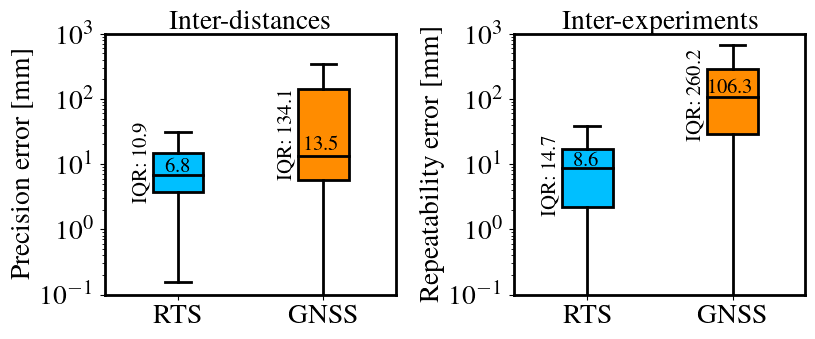

In [248]:
data1 = [precision_rts, precision_gps]
data2 = [error_rts_inter_experiment, error_inter_experiment]

data = data1+data2

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=10)
font_size = 20

fig, ax = plt.subplots(figsize = (7.5,4.5) ,ncols=2, nrows=1)
fig.subplots_adjust(left=.13, bottom=.13, right=.99, top=.99,wspace=3)

ax[0].set_alpha(0.2)
ax[1].set_alpha(0.2)

box1 = ax[0].boxplot(data1, notch=False, patch_artist=True, vert = 1, showfliers=False, showmeans=False, widths=0.35)
box2 = ax[1].boxplot(data2, notch=False, patch_artist=True, vert = 1, showfliers=False, showmeans=False, widths=0.35)

box1['boxes'][0].set(facecolor='deepskyblue', linewidth=2)
box1['boxes'][1].set(facecolor='darkorange', linewidth=2)
box2['boxes'][0].set(facecolor='deepskyblue', linewidth=2)
box2['boxes'][1].set(facecolor='darkorange', linewidth=2)

for median in box1['medians']:
    median.set_color('black')
for median in box2['medians']:
    median.set_color('black')

for median in box1['medians']:
    median.set_linewidth(2)
for median in box2['medians']:
    median.set_linewidth(2)

for cap in box1['caps']:
    cap.set_linewidth(2)
for cap in box2['caps']:
    cap.set_linewidth(2)

for whisker in box1['whiskers']:
    whisker.set_linewidth(2)
for whisker in box2['whiskers']:
    whisker.set_linewidth(2)

for spine in ax[0].spines.values():
    spine.set_linewidth(2)
for spine in ax[1].spines.values():
    spine.set_linewidth(2)

font_size_numbers = 15


ax[0].text(1, np.round(np.median(data1[0]),1) +1, str(np.round(np.median(data1[0]),1)), horizontalalignment='center',fontsize = font_size_numbers)
ax[0].text(2, np.round(np.median(data1[1]),1) +3, str(np.round(np.median(data1[1]),1)), horizontalalignment='center',fontsize = font_size_numbers)
ax[1].text(1, np.round(np.median(data2[0]),1) +1, str(np.round(np.median(data2[0]),1)), horizontalalignment='center',fontsize = font_size_numbers)
ax[1].text(2, np.round(np.median(data2[1]),1) +20, str(np.round(np.median(data2[1]),1)), horizontalalignment='center',fontsize = font_size_numbers)

ax[0].text(0.75, np.round(np.percentile(data1[0], 5, interpolation='midpoint'),1)+1, 'IQR: '+str(np.round(np.percentile(data1[0], 75, interpolation='midpoint')-np.percentile(data1[0], 25, interpolation='midpoint'),1)), horizontalalignment='center',fontsize = font_size_numbers, rotation=90)
ax[0].text(1.75, np.round(np.percentile(data1[1], 25, interpolation='midpoint'),1)+1, 'IQR: '+str(np.round(np.percentile(data1[1], 75, interpolation='midpoint')-np.percentile(data1[1], 25, interpolation='midpoint'),1)), horizontalalignment='center',fontsize = font_size_numbers, rotation=90)
ax[1].text(0.75, np.round(np.percentile(data2[0], 4, interpolation='midpoint'),1)+1, 'IQR: '+str(np.round(np.percentile(data2[0], 75, interpolation='midpoint')-np.percentile(data2[0], 25, interpolation='midpoint'),1)), horizontalalignment='center',fontsize = font_size_numbers, rotation=90)
ax[1].text(1.75, np.round(np.percentile(data2[1], 23.5, interpolation='midpoint'),1)+1, 'IQR: '+str(np.round(np.percentile(data2[1], 75, interpolation='midpoint')-np.percentile(data2[1], 25, interpolation='midpoint'),1)), horizontalalignment='center',fontsize = font_size_numbers, rotation=90)

ax[0].text(1.5, 1200, 'Inter-distances', horizontalalignment='center',fontsize = font_size)
ax[1].text(1.5, 1200, 'Inter-experiments', horizontalalignment='center',fontsize = font_size)


ax[0].set_xticklabels(['RTS','GNSS'], fontsize=font_size)
ax[1].set_xticklabels(['RTS','GNSS'], fontsize=font_size)
ax[0].set_ylabel('Precision error [mm]',fontsize = font_size, labelpad=5)
ax[1].set_ylabel('Repeatability error [mm]',fontsize = font_size, labelpad=5)


ax[0].tick_params(axis='y', which='major', labelsize=font_size)
ax[1].get_yaxis().set_ticks([])
ax[1].tick_params(axis='y', which='major', labelsize=font_size)

# ax[0].set_aspect(0.08)
# ax[1].set_aspect(0.08)
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_ylim([0.1, 1000])
ax[1].set_ylim([0.1, 1000])

fig.set_size_inches(8.5, 3.5)
plt.tight_layout()
plt.savefig(os.path.expanduser('~') + '/boxplot_inter.png', bbox_inches='tight')